In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", font_scale=1.5)
# Handle date time conversions between pandas and matplotlib
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from matplotlib.pyplot import text
from google.colab import data_table
data_table.enable_dataframe_formatter()

new function from rep 5

In [2]:
def co2in_read(co2in_path,temp_path,start,end):

#-------------------------------- co2 in data--------------------------------
  df = pd.read_excel(co2in_path) # reading the raw date (xlsx)
  # combine columns to datime:
  time = (pd.to_datetime(df['Hour'].astype(str) + ':' + df['Minute'].astype(str), format='%H:%M').dt.time)
  df['Time'] = time
  df['Year'] = 2022
  df['Timestap'] = pd.to_datetime(df[["Year", "Month", "Day",'Hour','Minute']])
  df = df.set_index(df['Timestap'])
  df_clean = df[['Rec No.', 'CO2', 'Error']]
  df_clean = df_clean.resample('1min').mean() # resample the data for comparing the with temp and co2 out

#-------------------------------- Temp data--------------------------------

  # loading the temp data:
  df_temp = pd.read_csv(temp_path) # reading the raw date (csv)
  df_temp = df_temp.set_index('Time')
  df_temp.index = pd.to_datetime(df_temp.index) # convert to datime format
  df_temp = df_temp.resample('1min').mean()
  df_temp = df_temp.interpolate() # interpolate Nan values
  plt.plot(df_temp)


#-------------------------------- Join the 2 dfs to one--------------------------------
  
  # Join the 3 dfs to one
  df_exp = df_temp[start:end]
  df_exp['co2_in'] = df_clean['CO2'].loc[start:end] #co2 in data
  time_values = np.arange(1, len(df_exp['co2_in'])+1)
  time_values=time_values.tolist()
  df_exp["time(min)"] = time_values
  return df_exp

In [3]:
def co2in_read_new(co2in_path,temp_path,start,end):

#-------------------------------- co2 in data--------------------------------
  df = pd.read_excel(co2in_path) # reading the raw date (xlsx)
  # combine columns to datime:
  df = df.interpolate()
  df['Hour'] = df['Hour'].astype(int)
  df['Minute'] = df['Minute'].astype(int)
  df['Month'] = df['Month'].astype(int)
  df['Day'] = df['Day'].astype(int)
  df['Year'] = 2022

  time = (pd.to_datetime(df['Hour'].astype(str) + ':' + df['Minute'].astype(str), format='%H:%M').dt.time)
  df['Time'] = time
  df['Timestap'] = pd.to_datetime(df[["Year", "Month", "Day",'Hour','Minute']])
  df_clean = df[['Timestap','Rec No.', 'CO2', 'Error']]
  df_clean = df_clean.set_index(df_clean['Timestap'])
  df_clean = df_clean.resample('1min').mean() # resample the data for comparing the with temp and co2 out
  plt.plot(df_clean['CO2'])

#-------------------------------- Temp data--------------------------------

  # loading the temp data:
  df_temp = pd.read_csv(temp_path) # reading the raw date (csv)
  df_temp = df_temp.set_index('Time')
  df_temp.index = pd.to_datetime(df_temp.index) # convert to datime format
  df_temp = df_temp.resample('1min').mean()
  df_temp = df_temp.interpolate() # interpolate Nan values
  plt.plot(df_temp)


#-------------------------------- Join the 2 dfs to one--------------------------------
  
  # Join the 3 dfs to one
  df_exp = df_temp[start:end]
  df_exp['co2_in'] = df_clean['CO2'].loc[start:end] #co2 in data
  time_values = np.arange(1, len(df_exp['co2_in'])+1)
  time_values=time_values.tolist()
  df_exp["time(min)"] = time_values
  return df_exp

$CO_2$ *file*

In [4]:
# importing the essential libraries
import pandas as pd
import subprocess
import os
import time
from pathlib import Path
import logging
import requests
import fnmatch, shutil

#########Instructions#########
# 1. Define paths to .dat file and project folder.
# 2. Go to csv_to_df function, and edit the wanted columns in your dataframe.
# 3. Run all.
# 4. Have fun with your new pandas dataframe.
##############################


#################DEFINE PATHS HERE, and then RUN ALL#################
# global vars
data_folder_path = "/content/drive/MyDrive/Greenwall/co2_and_counting_people" # path to your project folder (where the csv is going to be saved)
file_dat_source = "/content/drive/MyDrive/Greenwall/co2_and_counting_people/Co2_different_rooms_exp/CR1000_M&M-VSLab_indoor_ProgRas (4).dat" # direct path to original .dat file 
######################################################################

# dat to csv conversion
def downloadCsv(file_dat_source):

    t = time.localtime()
    timestamp = time.strftime('%b-%d-%Y_%H%M', t)
    

    #url = 'link' # link to the *.dat file  - UNCOMMENT IF YOU WANT TO DOWNLOAD FROM URL
    #r = requests.get(url, allow_redirects=True) - UNCOMMENT IF YOU WANT TO DOWNLOAD FROM URL
    
    
    file_dat = f'{data_folder_path}/{timestamp}.dat'
    file_csv = f'{data_folder_path}/{timestamp}.csv'
    latest_csv = f'{data_folder_path}/latest1.csv'
    shutil.copyfile(file_dat_source, file_dat) # making a copy of the latest dat (source)
    
    #open(file_dat, 'wb').write(r.content) # download source *.dat file from url to local - UNCOMMENT IF YOU WANT TO DOWNLOAD FROM URL

    # converting dat to csv
    with open(file_dat) as f:
        with open(file_csv, "w") as f1:
            next(f) # skip false header line
            for line in f:
                f1.write(line)

    shutil.copyfile(file_csv, latest_csv) # making a copy of the latest csv
       
    # remove temp dat+ csv files, leaving only latest.csv
    if os.path.exists(file_dat):
      os.remove(file_dat)
    if os.path.exists(file_csv):
      os.remove(file_csv)
   
# csv to pandas df conversion
def csv_to_df(data_folder_path):
  df = pd.read_csv(f'{data_folder_path}/latest.csv', parse_dates=['TIMESTAMP'], low_memory=False) #

  # convert columns to numeric values
  for col in df.columns:
    if col != "TIMESTAMP": 
      df[col] = df[col].astype(float, errors = 'ignore') 
      df.dropna(subset = [col], inplace=True)

  
  df = df[['TIMESTAMP','Par_Avg', 'Temp_in_Avg', 'Temp_out_Avg', 'Rh_in_Avg', 'Rh_out_Avg']] # choose your wanted columns from your df
  df = df.iloc[3:] #take the data, starting from the 3rd row (in your dat file, you may need a different start row)
  df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP']) # convert timestamp column to datetime object type
  return df

##########CALLING THE FUNCTIONS##########
# calling the functions to convert dat->csv->pandas df
downloadCsv(file_dat_source) #don't forget to define paths at top
my_df = csv_to_df(data_folder_path) # your dataf

FileNotFoundError: ignored

In [ ]:
path= "/content/drive/MyDrive/Greenwall/co2_and_counting_people/latest1.csv"
df_co2_out = pd.read_csv(path) # reading the raw date (csv)
df_co2_out = df_co2_out[['TIMESTAMP','Valve_no', 'CO2_Avg']] # choose your wanted columns from your df
df_co2_out = df_co2_out.loc[df_co2_out['Valve_no']== 10] # we want the data from outside - valve 10
df_co2_out['TIMESTAMP'] = pd.to_datetime(df_co2_out['TIMESTAMP'])
df_co2_out = df_co2_out.iloc[3:] #take the data, starting from the 3rd row (in your dat file, you may need a different start row)
df_co2_out = df_co2_out.set_index('TIMESTAMP') #index column
df_co2_out = df_co2_out.resample('1min').mean()
df_co2_out['CO2_Avg'] = df_co2_out['CO2_Avg'].interpolate() # interpolate Nan values
df_co2_out = df_co2_out.loc[df_co2_out['Valve_no']== 10]
df_co2_out['CO2_Avg'] = df_co2_out['CO2_Avg'].interpolate()

def co2col(df_co2,df,start,end):
  df['co2_out'] = df_co2['CO2_Avg'][start:end]
  df['co2_out'] = df['co2_out'].interpolate()
  df['diff'] = df['co2_in']-df['co2_out']



  return df

In [ ]:
df_co2_out

Valve_no  CO2_Avg
TIMESTAMP                             
2021-06-17 07:55:00      10.0   424.70
2021-06-17 07:56:00      10.0   424.65
2021-06-17 08:24:00      10.0   422.75
2021-06-17 08:25:00      10.0   422.80
2021-06-17 08:26:00      10.0   421.25
...                       ...      ...
2022-05-02 10:13:00      10.0   374.00
2022-05-02 10:14:00      10.0   374.60
2022-05-02 10:42:00      10.0   370.90
2022-05-02 10:43:00      10.0   371.90
2022-05-02 10:44:00      10.0   369.30

[45915 rows x 2 columns]

# Repition 1  - new exp

In [ ]:
# loading the data:
file_path = "/content/drive/Othercomputers/My Computer/Desktop/Greenwall/co2_and_counting_people/Co2_different_rooms_exp/rep1_room/22_02_2022_1.xlsx"
df = pd.read_excel(file_path) # reading the raw date (xlsx)
# combine columns to datime:
time = (pd.to_datetime(df['Hour'].astype(str) + ':' + df['Minute'].astype(str), format='%H:%M').dt.time)
df['Time'] = time
df['Year'] = 2022
df['Timestap'] = pd.to_datetime(df[["Year", "Month", "Day",'Hour','Minute']])
df = df.set_index(df['Timestap'])
df_clean = df[['Rec No.', 'CO2', 'Error']]
df_clean = df_clean.resample('1min').mean() # resample the data for comparing the with temp and co2 out
df_clean

Rec No.         CO2  Error
Timestap                                       
2022-02-20 12:50:00      5.0  495.500000    0.0
2022-02-20 12:51:00     69.0  510.833333    0.0
2022-02-20 12:52:00    188.0  516.915254    0.0
2022-02-20 12:53:00    307.0  523.566667    0.0
2022-02-20 12:54:00    426.0  542.016949    0.0
...                      ...         ...    ...
2022-02-23 10:52:00   6161.0  566.000000    0.0
2022-02-23 10:53:00   6280.0  564.881356    0.0
2022-02-23 10:54:00   6399.0  565.483333    0.0
2022-02-23 10:55:00   6518.0  565.237288    0.0
2022-02-23 10:56:00   6600.0  567.608696    0.0

[4207 rows x 3 columns]

In [ ]:
df.dtypes

Tag(M3)             object
ID                   int64
Rec No.              int64
Day                  int64
Month                int64
Hour                 int64
Minute               int64
CO2                  int64
H2O                  int64
O2                   int64
Flow                 int64
Aux V                int64
Tair                 int64
Pressure           float64
Error                int64
Time                object
Year                 int64
Timestap    datetime64[ns]
dtype: object

### **Temp Data**

##### We need to fill all Nan values. we will do it with interpolation

11_closet_north
Time                                
2022-02-21 17:40:00            19.00
2022-02-21 17:41:00            19.00
2022-02-21 17:42:00            19.00
2022-02-21 17:43:00            19.00
2022-02-21 17:44:00            19.00
...                              ...
2022-02-23 17:31:00            21.25
2022-02-23 17:32:00            21.25
2022-02-23 17:33:00            21.25
2022-02-23 17:34:00            21.25
2022-02-23 17:35:00            21.25

[2876 rows x 1 columns]

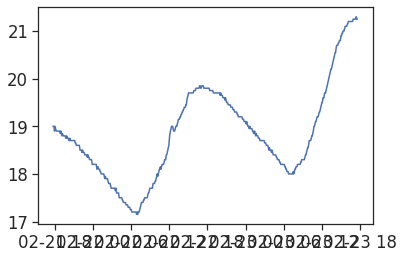

In [ ]:
# loading the data:
path= "/content/drive/Othercomputers/My Computer/Desktop/Greenwall/co2_and_counting_people/Co2_different_rooms_exp/rep1_room/lab_temp-data-2022-02-23 17_38_32.csv"
df_temp = pd.read_csv(path) # reading the raw date (csv)
df_temp = df_temp.set_index('Time')
df_temp.index = pd.to_datetime(df_temp.index) # convert to datime format
df_temp = df_temp.resample('1min').mean()
df_temp = df_temp.interpolate() # interpolate Nan values
plt.plot(df_temp)
df_temp

### CO2 data

In [ ]:
# importing the essential libraries
import pandas as pd
import subprocess
import os
import time
from pathlib import Path
import logging
import requests
import fnmatch, shutil

#########Instructions#########
# 1. Define paths to .dat file and project folder.
# 2. Go to csv_to_df function, and edit the wanted columns in your dataframe.
# 3. Run all.
# 4. Have fun with your new pandas dataframe.
##############################


#################DEFINE PATHS HERE, and then RUN ALL#################
# global vars
data_folder_path = "/content/drive/Othercomputers/My Computer/Desktop/Greenwall/co2_and_counting_people/Co2_different_rooms_exp/rep1_room" # path to your project folder (where the csv is going to be saved)
file_dat_source = "/content/drive/Othercomputers/My Computer/Desktop/Greenwall/co2_and_counting_people/Co2_different_rooms_exp/rep1_room/CR1000_M&M-VSLab_indoor_ProgRas.dat" # direct path to original .dat file 
######################################################################

# dat to csv conversion
def downloadCsv(file_dat_source):

    t = time.localtime()
    timestamp = time.strftime('%b-%d-%Y_%H%M', t)
    

    #url = 'link' # link to the *.dat file  - UNCOMMENT IF YOU WANT TO DOWNLOAD FROM URL
    #r = requests.get(url, allow_redirects=True) - UNCOMMENT IF YOU WANT TO DOWNLOAD FROM URL
    
    
    file_dat = f'{data_folder_path}/{timestamp}.dat'
    file_csv = f'{data_folder_path}/{timestamp}.csv'
    latest_csv = f'{data_folder_path}/latest.csv'
    shutil.copyfile(file_dat_source, file_dat) # making a copy of the latest dat (source)
    
    #open(file_dat, 'wb').write(r.content) # download source *.dat file from url to local - UNCOMMENT IF YOU WANT TO DOWNLOAD FROM URL

    # converting dat to csv
    with open(file_dat) as f:
        with open(file_csv, "w") as f1:
            next(f) # skip false header line
            for line in f:
                f1.write(line)

    shutil.copyfile(file_csv, latest_csv) # making a copy of the latest csv
       
    # remove temp dat+ csv files, leaving only latest.csv
    if os.path.exists(file_dat):
      os.remove(file_dat)
    if os.path.exists(file_csv):
      os.remove(file_csv)
   
# csv to pandas df conversion
def csv_to_df(data_folder_path):
  df = pd.read_csv(f'{data_folder_path}/latest.csv', parse_dates=['TIMESTAMP'], low_memory=False) #

  # convert columns to numeric values
  for col in df.columns:
    if col != "TIMESTAMP": 
      df[col] = df[col].astype(float, errors = 'ignore') 
      df.dropna(subset = [col], inplace=True)

  # df['Par_Avg'] = df['Par_Avg'].astype(float, errors = 'ignore') # convert columns to numeric values
  # df.dropna(subset = ['Par_Avg'], inplace=True)
  
  df = df[['TIMESTAMP','Par_Avg', 'Temp_in_Avg', 'Temp_out_Avg', 'Rh_in_Avg', 'Rh_out_Avg']] # choose your wanted columns from your df
  df = df.iloc[3:] #take the data, starting from the 3rd row (in your dat file, you may need a different start row)
  df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP']) # convert timestamp column to datetime object type
  return df

##########CALLING THE FUNCTIONS##########
# calling the functions to convert dat->csv->pandas df
downloadCsv(file_dat_source) #don't forget to define paths at top
my_df = csv_to_df(data_folder_path) # your dataframe object
#########################################

In [ ]:
path= "/content/drive/Othercomputers/My Computer/Desktop/Greenwall/co2_and_counting_people/Co2_different_rooms_exp/rep1_room/latest.csv"
df_co2_out = pd.read_csv(path) # reading the raw date (csv)
df_co2_out = df_co2_out[['TIMESTAMP','Valve_no', 'CO2_Avg']] # choose your wanted columns from your df
df_co2_out = df_co2_out.loc[df_co2_out['Valve_no']== 10] # we want the data from outside - valve 10
df_co2_out['TIMESTAMP'] = pd.to_datetime(df_co2_out['TIMESTAMP'])
df_co2_out = df_co2_out.iloc[3:] #take the data, starting from the 3rd row (in your dat file, you may need a different start row)
df_co2_out = df_co2_out.set_index('TIMESTAMP') #index column
df_co2_out = df_co2_out.resample('1min').mean()
df_co2_out['CO2_Avg'] = df_co2_out['CO2_Avg'].interpolate() # interpolate Nan values

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


One df for all the relevant data:

In [ ]:
start,end = '2022-02-22 15:49:00','2022-02-23 10:30:00'
df_exp1 =df_temp[start:end] 
df_exp1['co2_in'] = df_clean['CO2'].loc[start:end] #co2 in data
df_exp1['co2_out'] = df_co2_out['CO2_Avg'].loc[start:end] #co2 out data

# I want the time to be absulute and not a datime:
time_values = np.arange(1, len(df_exp1['co2_in'])+1)
time_values=time_values.tolist()
df_exp1["time(min)"] = time_values
df_exp1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

11_closet_north      co2_in     co2_out  time(min)
Time                                                                   
2022-02-22 15:49:00            19.74  653.086207  389.800000          1
2022-02-22 15:50:00            19.75  650.152542  388.900000          2
2022-02-22 15:51:00            19.75  650.816667  388.860714          3
2022-02-22 15:52:00            19.75  663.288136  388.821429          4
2022-02-22 15:53:00            19.75  723.666667  388.782143          5
...                              ...         ...         ...        ...
2022-02-23 10:26:00            18.80  567.933333  394.614286       1118
2022-02-23 10:27:00            18.80  568.372881  394.475000       1119
2022-02-23 10:28:00            18.80  569.450000  394.335714       1120
2022-02-23 10:29:00            18.80  568.593220  394.196429       1121
2022-02-23 10:30:00            18.80  568.716667  394.057143       1122

[1122 rows x 4 columns]

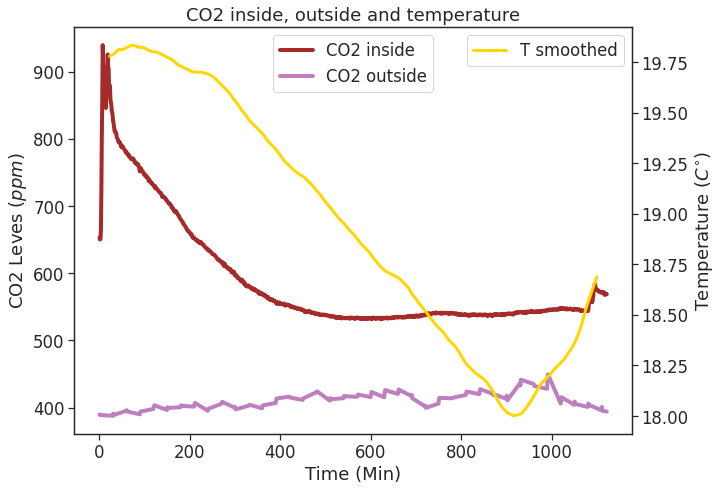

In [ ]:
# graph
fig, ax = plt.subplots(1, figsize=(10,7.5))
ax.plot(df_exp1["time(min)"],df_exp1['co2_in'],color = "brown",label='CO2 inside',  linewidth=4)
ax.plot(df_exp1["time(min)"],df_exp1['co2_out'],color = "purple",label='CO2 outside',  linewidth=4,alpha=.5)
ax.set(xlabel="Time (Min)",
       ylabel="CO2 Leves ($ppm$)",
       title="CO2 inside, outside and temperature");
#ax.set_xlim(0,500)
plt.legend(loc='upper center')
ax2 = ax.twinx()
# ax2.plot(df_exp1["time(min)"],df_exp1['11_closet_north'],color = "seagreen",label='Temperature',  linewidth=3)
ax2.plot(df_exp1["time(min)"],df_exp1['11_closet_north'].rolling(45, center=True).mean(),color = "gold", label="T smoothed",linewidth=3, linestyle= "-")
ax2.set(xlabel="Time (Min)",
       ylabel="Temperature ($C^{\circ}$)");
# plt.axhline(y=0, color = "black")
plt.legend(loc='best')
save_results_to = '/content/drive/Othercomputers/My Computer/Desktop/Greenwall/co2_and_counting_people/Co2_different_rooms_exp/rep1_room/'
plt.savefig(save_results_to + 'rep1_room.png')

# Repition 2  - new exp

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


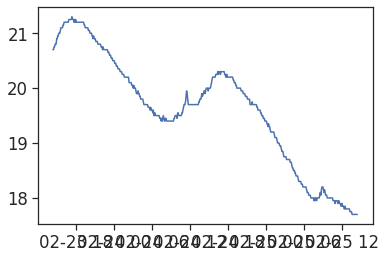

In [ ]:
df_exp2 = co2in_read("/content/drive/Othercomputers/My Computer/Desktop/Greenwall/co2_and_counting_people/Co2_different_rooms_exp/rep2_room/rep2.xlsx","/content/drive/Othercomputers/My Computer/Desktop/Greenwall/co2_and_counting_people/Co2_different_rooms_exp/rep2_room/lab_temp-data-2022-02-25 14_26_43.csv","2022-02-24 15:50:00","2022-02-25 10:00:00")

In [ ]:
# importing the essential libraries
import pandas as pd
import subprocess
import os
import time
from pathlib import Path
import logging
import requests
import fnmatch, shutil

#########Instructions#########
# 1. Define paths to .dat file and project folder.
# 2. Go to csv_to_df function, and edit the wanted columns in your dataframe.
# 3. Run all.
# 4. Have fun with your new pandas dataframe.
##############################


#################DEFINE PATHS HERE, and then RUN ALL#################
# global vars
data_folder_path = "/content/drive/Othercomputers/My Computer/Desktop/Greenwall/co2_and_counting_people/Co2_different_rooms_exp/rep2_room" # path to your project folder (where the csv is going to be saved)
file_dat_source = "/content/drive/Othercomputers/My Computer/Desktop/Greenwall/co2_and_counting_people/Co2_different_rooms_exp/rep2_room/CR1000_M&M-VSLab_indoor_ProgRas.dat" # direct path to original .dat file 
######################################################################

# dat to csv conversion
def downloadCsv(file_dat_source):

    t = time.localtime()
    timestamp = time.strftime('%b-%d-%Y_%H%M', t)
    

    #url = 'link' # link to the *.dat file  - UNCOMMENT IF YOU WANT TO DOWNLOAD FROM URL
    #r = requests.get(url, allow_redirects=True) - UNCOMMENT IF YOU WANT TO DOWNLOAD FROM URL
    
    
    file_dat = f'{data_folder_path}/{timestamp}.dat'
    file_csv = f'{data_folder_path}/{timestamp}.csv'
    latest_csv = f'{data_folder_path}/latest.csv'
    shutil.copyfile(file_dat_source, file_dat) # making a copy of the latest dat (source)
    
    #open(file_dat, 'wb').write(r.content) # download source *.dat file from url to local - UNCOMMENT IF YOU WANT TO DOWNLOAD FROM URL

    # converting dat to csv
    with open(file_dat) as f:
        with open(file_csv, "w") as f1:
            next(f) # skip false header line
            for line in f:
                f1.write(line)

    shutil.copyfile(file_csv, latest_csv) # making a copy of the latest csv
       
    # remove temp dat+ csv files, leaving only latest.csv
    if os.path.exists(file_dat):
      os.remove(file_dat)
    if os.path.exists(file_csv):
      os.remove(file_csv)
   
# csv to pandas df conversion
def csv_to_df(data_folder_path):
  df = pd.read_csv(f'{data_folder_path}/latest.csv', parse_dates=['TIMESTAMP'], low_memory=False) #

  # convert columns to numeric values
  for col in df.columns:
    if col != "TIMESTAMP": 
      df[col] = df[col].astype(float, errors = 'ignore') 
      df.dropna(subset = [col], inplace=True)

  # df['Par_Avg'] = df['Par_Avg'].astype(float, errors = 'ignore') # convert columns to numeric values
  # df.dropna(subset = ['Par_Avg'], inplace=True)
  
  df = df[['TIMESTAMP','Par_Avg', 'Temp_in_Avg', 'Temp_out_Avg', 'Rh_in_Avg', 'Rh_out_Avg']] # choose your wanted columns from your df
  df = df.iloc[3:] #take the data, starting from the 3rd row (in your dat file, you may need a different start row)
  df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP']) # convert timestamp column to datetime object type
  return df

##########CALLING THE FUNCTIONS##########
# calling the functions to convert dat->csv->pandas df
downloadCsv(file_dat_source) #don't forget to define paths at top
my_df = csv_to_df(data_folder_path) # your dataframe object
#########################################

In [ ]:
path= "/content/drive/Othercomputers/My Computer/Desktop/Greenwall/co2_and_counting_people/Co2_different_rooms_exp/rep2_room/latest.csv"
df_co2_out = pd.read_csv(path) # reading the raw date (csv)
df_co2_out = df_co2_out[['TIMESTAMP','Valve_no', 'CO2_Avg']] # choose your wanted columns from your df
df_co2_out = df_co2_out.loc[df_co2_out['Valve_no']== 10] # we want the data from outside - valve 10
df_co2_out['TIMESTAMP'] = pd.to_datetime(df_co2_out['TIMESTAMP'])
df_co2_out = df_co2_out.iloc[3:] #take the data, starting from the 3rd row (in your dat file, you may need a different start row)
df_co2_out = df_co2_out.set_index('TIMESTAMP') #index column
df_co2_out = df_co2_out.resample('1min').mean()
df_co2_out['CO2_Avg'] = df_co2_out['CO2_Avg'].interpolate() # interpolate Nan values
start,end ="2022-02-24 15:50:00", "2022-02-25 10:00:00"
df_exp2['co2_out'] = df_co2_out['CO2_Avg'].loc[start:end] #co2 out data
df_exp2

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


11_closet_north      co2_in  time(min)     co2_out
Time                                                                   
2022-02-24 15:50:00             20.2  538.233333          1  380.000000
2022-02-24 15:51:00             20.2  539.559322          2  380.087500
2022-02-24 15:52:00             20.2  539.466667          3  380.175000
2022-02-24 15:53:00             20.2  539.864407          4  380.262500
2022-02-24 15:54:00             20.2  540.216667          5  380.350000
...                              ...         ...        ...         ...
2022-02-25 09:56:00             18.0  519.322034       1087  374.517857
2022-02-25 09:57:00             18.0  519.316667       1088  374.462500
2022-02-25 09:58:00             18.0  519.610169       1089  374.407143
2022-02-25 09:59:00             18.0  519.271186       1090  374.351786
2022-02-25 10:00:00             18.0  519.683333       1091  374.296429

[1091 rows x 4 columns]

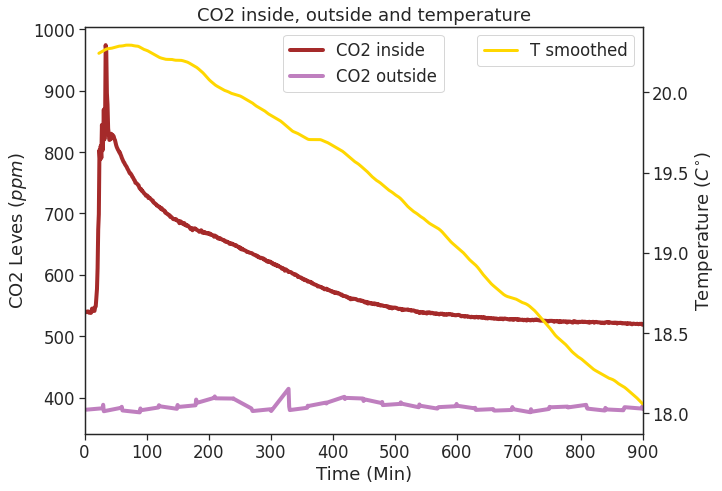

In [ ]:
# graph
fig, ax = plt.subplots(1, figsize=(10,7.5))
ax.plot(df_exp2["time(min)"],df_exp2['co2_in'],color = "brown",label='CO2 inside',  linewidth=4)
ax.plot(df_exp2["time(min)"],df_exp2['co2_out'],color = "purple",label='CO2 outside',  linewidth=4,alpha=.5)
ax.set(xlabel="Time (Min)",
       ylabel="CO2 Leves ($ppm$)",
       title="CO2 inside, outside and temperature");
ax.set_xlim(0,900)
plt.legend(loc='upper center')
ax2 = ax.twinx()
# ax2.plot(df_exp2["time(min)"],df_exp2['11_closet_north'],color = "seagreen",label='Temperature',  linewidth=3)
ax2.plot(df_exp2["time(min)"],df_exp2['11_closet_north'].rolling(45, center=True).mean(),color = "gold", label="T smoothed",linewidth=3, linestyle= "-")
ax2.set(xlabel="Time (Min)",
       ylabel="Temperature ($C^{\circ}$)");
# plt.axhline(y=0, color = "black")
plt.legend(loc='best')
# save_results_to = '/content/drive/Othercomputers/My Computer/Desktop/Greenwall/co2_and_counting_people/Co2_different_rooms_exp/rep2_room/'
# plt.savefig(save_results_to + 'rep2_room.png')

# Repition 3  - new exp

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


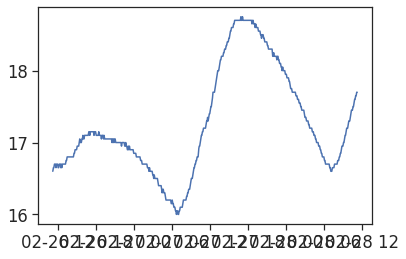

In [ ]:
df_exp3 = co2in_read("/content/drive/Othercomputers/My Computer/Desktop/Greenwall/co2_and_counting_people/Co2_different_rooms_exp/rep3_room/rep3.xlsx","/content/drive/Othercomputers/My Computer/Desktop/Greenwall/co2_and_counting_people/Co2_different_rooms_exp/rep3_room/lab_temp-data-2022-02-28 11_14_26.csv","2022-02-27 11:20:00","2022-02-28 04:00:00")

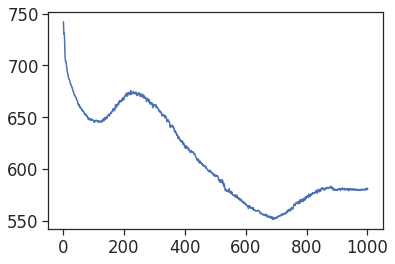

In [ ]:
plt.plot(df_exp3['time(min)'],df_exp3['co2_in'])

In [ ]:
# importing the essential libraries
import pandas as pd
import subprocess
import os
import time
from pathlib import Path
import logging
import requests
import fnmatch, shutil

#########Instructions#########
# 1. Define paths to .dat file and project folder.
# 2. Go to csv_to_df function, and edit the wanted columns in your dataframe.
# 3. Run all.
# 4. Have fun with your new pandas dataframe.
##############################


#################DEFINE PATHS HERE, and then RUN ALL#################
# global vars
data_folder_path = "/content/drive/Othercomputers/My Computer/Desktop/Greenwall/co2_and_counting_people/Co2_different_rooms_exp/rep3_room" # path to your project folder (where the csv is going to be saved)
file_dat_source = "/content/drive/Othercomputers/My Computer/Desktop/Greenwall/co2_and_counting_people/Co2_different_rooms_exp/rep3_room/CR1000_M&M-VSLab_indoor_ProgRas.dat" # direct path to original .dat file 
######################################################################

# dat to csv conversion
def downloadCsv(file_dat_source):

    t = time.localtime()
    timestamp = time.strftime('%b-%d-%Y_%H%M', t)
    

    #url = 'link' # link to the *.dat file  - UNCOMMENT IF YOU WANT TO DOWNLOAD FROM URL
    #r = requests.get(url, allow_redirects=True) - UNCOMMENT IF YOU WANT TO DOWNLOAD FROM URL
    
    
    file_dat = f'{data_folder_path}/{timestamp}.dat'
    file_csv = f'{data_folder_path}/{timestamp}.csv'
    latest_csv = f'{data_folder_path}/latest.csv'
    shutil.copyfile(file_dat_source, file_dat) # making a copy of the latest dat (source)
    
    #open(file_dat, 'wb').write(r.content) # download source *.dat file from url to local - UNCOMMENT IF YOU WANT TO DOWNLOAD FROM URL

    # converting dat to csv
    with open(file_dat) as f:
        with open(file_csv, "w") as f1:
            next(f) # skip false header line
            for line in f:
                f1.write(line)

    shutil.copyfile(file_csv, latest_csv) # making a copy of the latest csv
       
    # remove temp dat+ csv files, leaving only latest.csv
    if os.path.exists(file_dat):
      os.remove(file_dat)
    if os.path.exists(file_csv):
      os.remove(file_csv)
   
# csv to pandas df conversion
def csv_to_df(data_folder_path):
  df = pd.read_csv(f'{data_folder_path}/latest.csv', parse_dates=['TIMESTAMP'], low_memory=False) #

  # convert columns to numeric values
  for col in df.columns:
    if col != "TIMESTAMP": 
      df[col] = df[col].astype(float, errors = 'ignore') 
      df.dropna(subset = [col], inplace=True)

  
  df = df[['TIMESTAMP','Par_Avg', 'Temp_in_Avg', 'Temp_out_Avg', 'Rh_in_Avg', 'Rh_out_Avg']] # choose your wanted columns from your df
  df = df.iloc[3:] #take the data, starting from the 3rd row (in your dat file, you may need a different start row)
  df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP']) # convert timestamp column to datetime object type
  return df

##########CALLING THE FUNCTIONS##########
# calling the functions to convert dat->csv->pandas df
downloadCsv(file_dat_source) #don't forget to define paths at top
my_df = csv_to_df(data_folder_path) # your dataf

In [ ]:
path= "/content/drive/Othercomputers/My Computer/Desktop/Greenwall/co2_and_counting_people/Co2_different_rooms_exp/rep3_room/latest.csv"
df_co2_out = pd.read_csv(path) # reading the raw date (csv)
df_co2_out = df_co2_out[['TIMESTAMP','Valve_no', 'CO2_Avg']] # choose your wanted columns from your df
df_co2_out = df_co2_out.loc[df_co2_out['Valve_no']== 10] # we want the data from outside - valve 10
df_co2_out['TIMESTAMP'] = pd.to_datetime(df_co2_out['TIMESTAMP'])
df_co2_out = df_co2_out.iloc[3:] #take the data, starting from the 3rd row (in your dat file, you may need a different start row)
df_co2_out = df_co2_out.set_index('TIMESTAMP') #index column
df_co2_out = df_co2_out.resample('1min').mean()
df_co2_out['CO2_Avg'] = df_co2_out['CO2_Avg'].interpolate() # interpolate Nan values
start,end ="2022-02-27 11:20:00","2022-02-28 04:00:00"
df_exp3['co2_out'] = df_co2_out['CO2_Avg'].loc[start:end] #co2 out data
df_exp3

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


11_closet_north      co2_in  time(min)     co2_out
Time                                                                   
2022-02-27 11:20:00            17.25  742.220339          1  375.250000
2022-02-27 11:21:00            17.26  733.750000          2  375.389286
2022-02-27 11:22:00            17.27  730.186441          3  375.528571
2022-02-27 11:23:00            17.28  730.966667          4  375.667857
2022-02-27 11:24:00            17.29  723.576271          5  375.807143
...                              ...         ...        ...         ...
2022-02-28 03:56:00            17.20  580.400000        997  414.257143
2022-02-28 03:57:00            17.20  580.627119        998  414.400000
2022-02-28 03:58:00            17.20  580.533333        999  414.542857
2022-02-28 03:59:00            17.20  581.288136       1000  414.685714
2022-02-28 04:00:00            17.20  580.716667       1001  414.828571

[1001 rows x 4 columns]

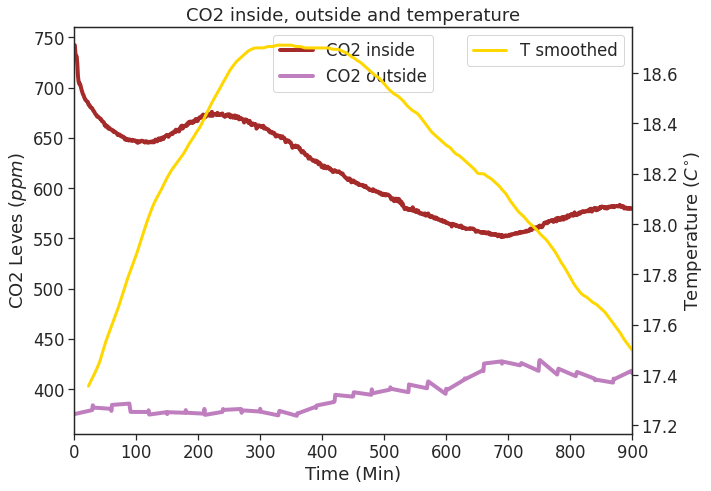

In [ ]:
# graph
fig, ax = plt.subplots(1, figsize=(10,7.5))
ax.plot(df_exp3["time(min)"],df_exp3['co2_in'],color = "brown",label='CO2 inside',  linewidth=4)
ax.plot(df_exp3["time(min)"],df_exp3['co2_out'],color = "purple",label='CO2 outside',  linewidth=4,alpha=.5)
ax.set(xlabel="Time (Min)",
       ylabel="CO2 Leves ($ppm$)",
       title="CO2 inside, outside and temperature");
ax.set_xlim(0,900)
plt.legend(loc='upper center')
ax2 = ax.twinx()
# ax2.plot(df_exp3["time(min)"],df_exp3['11_closet_north'],color = "seagreen",label='Temperature',  linewidth=3)
ax2.plot(df_exp3["time(min)"],df_exp3['11_closet_north'].rolling(45, center=True).mean(),color = "gold", label="T smoothed",linewidth=3, linestyle= "-")
ax2.set(xlabel="Time (Min)",
       ylabel="Temperature ($C^{\circ}$)");
# plt.axhline(y=0, color = "black")
plt.legend(loc='best')
# save_results_to = '/content/drive/Othercomputers/My Computer/Desktop/Greenwall/co2_and_counting_people/Co2_different_rooms_exp/rep3_room/'
# plt.savefig(save_results_to + 'rep3_room.png')

# Rep 4 -new exp

In [ ]:
# df_exp4 = co2in_read("/content/drive/Othercomputers/My Computer/Desktop/Greenwall/co2_and_counting_people/Co2_different_rooms_exp/rep4_room/co2_in_rep4.xlsx","/content/drive/Othercomputers/My Computer/Desktop/Greenwall/co2_and_counting_people/Co2_different_rooms_exp/rep4_room/lab_temp-data-2022-03-02 16_00_31.csv","2022-03-01 11:50:00","2022-03-02 04:00:00")
co2in_path= "/content/drive/Othercomputers/My Computer/Desktop/Greenwall/co2_and_counting_people/Co2_different_rooms_exp/rep4_room/co2_in_rep4.xlsx"
df = pd.read_excel(co2in_path) # reading the raw date (xlsx)
#   # combine columns to datime:


In [ ]:
df = df.interpolate()
df['Hour'] = df['Hour'].astype(int)
df['Minute'] = df['Minute'].astype(int)
df['Month'] = df['Month'].astype(int)
df['Day'] = df['Day'].astype(int)
df['Year'] = 2022

time = (pd.to_datetime(df['Hour'].astype(str) + ':' + df['Minute'].astype(str), format='%H:%M').dt.time)
df['Time'] = time
df['Timestap'] = pd.to_datetime(df[["Year", "Month", "Day",'Hour','Minute']])

In [ ]:
df_clean = df[['Timestap','Rec No.', 'CO2', 'Error']]
df_clean = df_clean.set_index(df_clean['Timestap'])
df_clean = df_clean.resample('1min').mean() # resample the data for comparing the with temp and co2 out
df_clean

Rec No.         CO2  Error
Timestap                                       
2022-03-01 11:00:00   8729.0  560.388889    0.0
2022-03-01 11:01:00   8842.0  558.237288    0.0
2022-03-01 11:02:00   8960.0  559.406780    0.0
2022-03-01 11:03:00   9079.0  560.216667    0.0
2022-03-01 11:04:00   9198.0  561.033898    0.0
...                      ...         ...    ...
2022-03-02 12:00:00   1819.0  454.716667    0.0
2022-03-02 12:01:00   1938.0  454.627119    0.0
2022-03-02 12:02:00   2057.0  454.016667    0.0
2022-03-02 12:03:00   2176.0  454.033898    0.0
2022-03-02 12:04:00   2276.0  454.341463    0.0

[1505 rows x 3 columns]

11_closet_north
Time                                
2022-02-28 16:00:00             19.2
2022-02-28 16:01:00             19.2
2022-02-28 16:02:00             19.2
2022-02-28 16:03:00             19.2
2022-02-28 16:04:00             19.2
...                              ...
2022-03-02 15:51:00             20.6
2022-03-02 15:52:00             20.6
2022-03-02 15:53:00             20.6
2022-03-02 15:54:00             20.6
2022-03-02 15:55:00             20.6

[2876 rows x 1 columns]

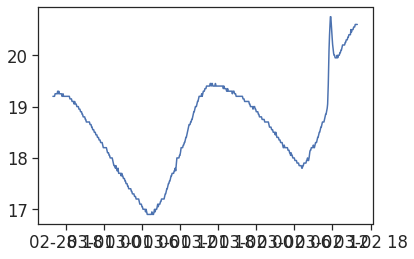

In [ ]:
# loading the data:
path= "/content/drive/Othercomputers/My Computer/Desktop/Greenwall/co2_and_counting_people/Co2_different_rooms_exp/rep4_room/lab_temp-data-2022-03-02 16_00_31.csv"
df_temp = pd.read_csv(path) # reading the raw date (csv)
df_temp = df_temp.set_index('Time')
df_temp.index = pd.to_datetime(df_temp.index) # convert to datime format
df_temp = df_temp.resample('1min').mean()
df_temp = df_temp.interpolate() # interpolate Nan values
plt.plot(df_temp)
df_temp

In [ ]:
# importing the essential libraries
import pandas as pd
import subprocess
import os
import time
from pathlib import Path
import logging
import requests
import fnmatch, shutil

#########Instructions#########
# 1. Define paths to .dat file and project folder.
# 2. Go to csv_to_df function, and edit the wanted columns in your dataframe.
# 3. Run all.
# 4. Have fun with your new pandas dataframe.
##############################


#################DEFINE PATHS HERE, and then RUN ALL#################
# global vars
data_folder_path = "/content/drive/Othercomputers/My Computer/Desktop/Greenwall/co2_and_counting_people/Co2_different_rooms_exp/rep4_room" # path to your project folder (where the csv is going to be saved)
file_dat_source = "/content/drive/Othercomputers/My Computer/Desktop/Greenwall/co2_and_counting_people/Co2_different_rooms_exp/rep4_room/CR1000_M&M-VSLab_indoor_ProgRas.dat" # direct path to original .dat file 
######################################################################

# dat to csv conversion
def downloadCsv(file_dat_source):

    t = time.localtime()
    timestamp = time.strftime('%b-%d-%Y_%H%M', t)
    

    #url = 'link' # link to the *.dat file  - UNCOMMENT IF YOU WANT TO DOWNLOAD FROM URL
    #r = requests.get(url, allow_redirects=True) - UNCOMMENT IF YOU WANT TO DOWNLOAD FROM URL
    
    
    file_dat = f'{data_folder_path}/{timestamp}.dat'
    file_csv = f'{data_folder_path}/{timestamp}.csv'
    latest_csv = f'{data_folder_path}/latest.csv'
    shutil.copyfile(file_dat_source, file_dat) # making a copy of the latest dat (source)
    
    #open(file_dat, 'wb').write(r.content) # download source *.dat file from url to local - UNCOMMENT IF YOU WANT TO DOWNLOAD FROM URL

    # converting dat to csv
    with open(file_dat) as f:
        with open(file_csv, "w") as f1:
            next(f) # skip false header line
            for line in f:
                f1.write(line)

    shutil.copyfile(file_csv, latest_csv) # making a copy of the latest csv
       
    # remove temp dat+ csv files, leaving only latest.csv
    if os.path.exists(file_dat):
      os.remove(file_dat)
    if os.path.exists(file_csv):
      os.remove(file_csv)
   
# csv to pandas df conversion
def csv_to_df(data_folder_path):
  df = pd.read_csv(f'{data_folder_path}/latest.csv', parse_dates=['TIMESTAMP'], low_memory=False) #

  # convert columns to numeric values
  for col in df.columns:
    if col != "TIMESTAMP": 
      df[col] = df[col].astype(float, errors = 'ignore') 
      df.dropna(subset = [col], inplace=True)

  
  df = df[['TIMESTAMP','Par_Avg', 'Temp_in_Avg', 'Temp_out_Avg', 'Rh_in_Avg', 'Rh_out_Avg']] # choose your wanted columns from your df
  df = df.iloc[3:] #take the data, starting from the 3rd row (in your dat file, you may need a different start row)
  df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP']) # convert timestamp column to datetime object type
  return df

##########CALLING THE FUNCTIONS##########
# calling the functions to convert dat->csv->pandas df
downloadCsv(file_dat_source) #don't forget to define paths at top
my_df = csv_to_df(data_folder_path) # your dataf

In [ ]:
path= "/content/drive/Othercomputers/My Computer/Desktop/Greenwall/co2_and_counting_people/Co2_different_rooms_exp/rep4_room/latest.csv"
df_co2_out = pd.read_csv(path) # reading the raw date (csv)
df_co2_out = df_co2_out[['TIMESTAMP','Valve_no', 'CO2_Avg']] # choose your wanted columns from your df
df_co2_out = df_co2_out.loc[df_co2_out['Valve_no']== 10] # we want the data from outside - valve 10
df_co2_out['TIMESTAMP'] = pd.to_datetime(df_co2_out['TIMESTAMP'])
df_co2_out = df_co2_out.iloc[3:] #take the data, starting from the 3rd row (in your dat file, you may need a different start row)
df_co2_out = df_co2_out.set_index('TIMESTAMP') #index column
df_co2_out = df_co2_out.resample('1min').mean()
df_co2_out['CO2_Avg'] = df_co2_out['CO2_Avg'].interpolate() # interpolate Nan values

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
start,end ="2022-03-01 11:50:00","2022-03-02 04:00:00"
df_temp =df_temp[start:end]
df_clean = df_clean[start:end]
# df_exp4 = df_co2_out[start:end]
df_exp4 = df_temp
df_exp4['co2_in'] = df_clean['CO2'] # for oresent them in the same graph i create  new df who incloud all co2 data
df_co2_out = df_co2_out.loc[df_co2_out['Valve_no']== 10] # we want the data from outside - valve 10
df_exp4['co2_out'] = df_co2_out['CO2_Avg'][start:end]
df_exp4['co2_out'] = df_exp4['co2_out'].interpolate() # for oresent them in the same graph i create  new df who incloud all co2 data

time_values = np.arange(1, len(df_exp4['co2_in'])+1)
time_values=time_values.tolist()
df_exp4["time(min)"] = time_values
df_exp4

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

11_closet_north      co2_in     co2_out  time(min)
Time                                                                   
2022-03-01 11:50:00            18.00  543.457627  382.450000          1
2022-03-01 11:51:00            18.01  544.300000  382.705357          2
2022-03-01 11:52:00            18.02  544.483051  382.960714          3
2022-03-01 11:53:00            18.03  545.008333  383.216071          4
2022-03-01 11:54:00            18.04  545.322034  383.471429          5
...                              ...         ...         ...        ...
2022-03-02 03:56:00            18.30  394.576271  404.450000        967
2022-03-02 03:57:00            18.30  394.350000  404.450000        968
2022-03-02 03:58:00            18.30  394.322034  404.450000        969
2022-03-02 03:59:00            18.30  394.400000  404.450000        970
2022-03-02 04:00:00            18.30  394.338983  404.450000        971

[971 rows x 4 columns]

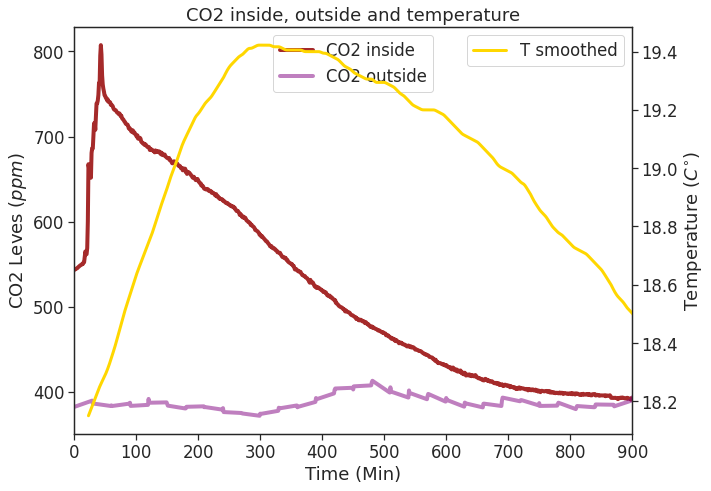

In [ ]:
# graph
fig, ax = plt.subplots(1, figsize=(10,7.5))
ax.plot(df_exp4["time(min)"],df_exp4['co2_in'],color = "brown",label='CO2 inside',  linewidth=4)
ax.plot(df_exp4["time(min)"],df_exp4['co2_out'],color = "purple",label='CO2 outside',  linewidth=4,alpha=.5)
ax.set(xlabel="Time (Min)",
       ylabel="CO2 Leves ($ppm$)",
       title="CO2 inside, outside and temperature");
ax.set_xlim(0,900)
plt.legend(loc='upper center')
ax2 = ax.twinx()
# ax2.plot(df_exp4["time(min)"],df_exp4['11_closet_north'],color = "seagreen",label='Temperature',  linewidth=3)
ax2.plot(df_exp4["time(min)"],df_exp4['11_closet_north'].rolling(45, center=True).mean(),color = "gold", label="T smoothed",linewidth=3, linestyle= "-")
ax2.set(xlabel="Time (Min)",
       ylabel="Temperature ($C^{\circ}$)");
# plt.axhline(y=0, color = "black")
plt.legend(loc='best')
save_results_to = '/content/drive/Othercomputers/My Computer/Desktop/Greenwall/co2_and_counting_people/Co2_different_rooms_exp/rep4_room/'
plt.savefig(save_results_to + 'rep4_room.png')

# rep 5 - New exp

In [ ]:
# df_exp5 = co2in_read("","","2022-03-10 11:20:00","2022-03-11 04:00:00")
co2in_path= "/content/drive/Othercomputers/My Computer/Desktop/Greenwall/co2_and_counting_people/Co2_different_rooms_exp/rep5_room/co2_in.xlsx"
df = pd.read_excel(co2in_path) # reading the raw date (xlsx)
#   # combine columns to datime:

In [ ]:
df = df.interpolate()
df['Hour'] = df['Hour'].astype(int)
df['Minute'] = df['Minute'].astype(int)
df['Month'] = df['Month'].astype(int)
df['Day'] = df['Day'].astype(int)
df['Year'] = 2022

time = (pd.to_datetime(df['Hour'].astype(str) + ':' + df['Minute'].astype(str), format='%H:%M').dt.time)
df['Time'] = time
df['Timestap'] = pd.to_datetime(df[["Year", "Month", "Day",'Hour','Minute']])

In [ ]:
df_clean = df[['Timestap','Rec No.', 'CO2', 'Error']]
df_clean = df_clean.set_index(df_clean['Timestap'])
df_clean = df_clean.resample('1min').mean() # resample the data for comparing the with temp and co2 out
df_clean

Output hidden; open in https://colab.research.google.com to view.

11_closet_north
Time                                
2022-03-06 10:40:00            17.80
2022-03-06 10:41:00            17.81
2022-03-06 10:42:00            17.82
2022-03-06 10:43:00            17.83
2022-03-06 10:44:00            17.84
...                              ...
2022-03-13 10:36:00            13.76
2022-03-13 10:37:00            13.77
2022-03-13 10:38:00            13.78
2022-03-13 10:39:00            13.79
2022-03-13 10:40:00            13.80

[10081 rows x 1 columns]

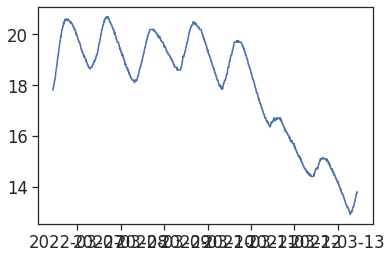

In [ ]:
# loading the data:
path= "/content/drive/Othercomputers/My Computer/Desktop/Greenwall/co2_and_counting_people/Co2_different_rooms_exp/rep5_room/lab_temp-data-2022-03-13 10_43_42.csv"
df_temp = pd.read_csv(path) # reading the raw date (csv)
df_temp = df_temp.set_index('Time')
df_temp.index = pd.to_datetime(df_temp.index) # convert to datime format
df_temp = df_temp.resample('1min').mean()
df_temp = df_temp.interpolate() # interpolate Nan values
plt.plot(df_temp)
df_temp

In [ ]:
# importing the essential libraries
import pandas as pd
import subprocess
import os
import time
from pathlib import Path
import logging
import requests
import fnmatch, shutil

#########Instructions#########
# 1. Define paths to .dat file and project folder.
# 2. Go to csv_to_df function, and edit the wanted columns in your dataframe.
# 3. Run all.
# 4. Have fun with your new pandas dataframe.
##############################


#################DEFINE PATHS HERE, and then RUN ALL#################
# global vars
data_folder_path = "/content/drive/Othercomputers/My Computer/Desktop/Greenwall/co2_and_counting_people/Co2_different_rooms_exp/rep5_room" # path to your project folder (where the csv is going to be saved)
file_dat_source = "/content/drive/Othercomputers/My Computer/Desktop/Greenwall/co2_and_counting_people/Co2_different_rooms_exp/rep5_room/CR1000_M&M-VSLab_indoor_ProgRas.dat" # direct path to original .dat file 
######################################################################

# dat to csv conversion
def downloadCsv(file_dat_source):

    t = time.localtime()
    timestamp = time.strftime('%b-%d-%Y_%H%M', t)
    

    #url = 'link' # link to the *.dat file  - UNCOMMENT IF YOU WANT TO DOWNLOAD FROM URL
    #r = requests.get(url, allow_redirects=True) - UNCOMMENT IF YOU WANT TO DOWNLOAD FROM URL
    
    
    file_dat = f'{data_folder_path}/{timestamp}.dat'
    file_csv = f'{data_folder_path}/{timestamp}.csv'
    latest_csv = f'{data_folder_path}/latest.csv'
    shutil.copyfile(file_dat_source, file_dat) # making a copy of the latest dat (source)
    
    #open(file_dat, 'wb').write(r.content) # download source *.dat file from url to local - UNCOMMENT IF YOU WANT TO DOWNLOAD FROM URL

    # converting dat to csv
    with open(file_dat) as f:
        with open(file_csv, "w") as f1:
            next(f) # skip false header line
            for line in f:
                f1.write(line)

    shutil.copyfile(file_csv, latest_csv) # making a copy of the latest csv
       
    # remove temp dat+ csv files, leaving only latest.csv
    if os.path.exists(file_dat):
      os.remove(file_dat)
    if os.path.exists(file_csv):
      os.remove(file_csv)
   
# csv to pandas df conversion
def csv_to_df(data_folder_path):
  df = pd.read_csv(f'{data_folder_path}/latest.csv', parse_dates=['TIMESTAMP'], low_memory=False) #

  # convert columns to numeric values
  for col in df.columns:
    if col != "TIMESTAMP": 
      df[col] = df[col].astype(float, errors = 'ignore') 
      df.dropna(subset = [col], inplace=True)

  
  df = df[['TIMESTAMP','Par_Avg', 'Temp_in_Avg', 'Temp_out_Avg', 'Rh_in_Avg', 'Rh_out_Avg']] # choose your wanted columns from your df
  df = df.iloc[3:] #take the data, starting from the 3rd row (in your dat file, you may need a different start row)
  df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP']) # convert timestamp column to datetime object type
  return df

##########CALLING THE FUNCTIONS##########
# calling the functions to convert dat->csv->pandas df
downloadCsv(file_dat_source) #don't forget to define paths at top
my_df = csv_to_df(data_folder_path) # your dataf

In [ ]:
path= "/content/drive/Othercomputers/My Computer/Desktop/Greenwall/co2_and_counting_people/Co2_different_rooms_exp/rep5_room/latest.csv"
df_co2_out = pd.read_csv(path) # reading the raw date (csv)
df_co2_out = df_co2_out[['TIMESTAMP','Valve_no', 'CO2_Avg']] # choose your wanted columns from your df
df_co2_out = df_co2_out.loc[df_co2_out['Valve_no']== 10] # we want the data from outside - valve 10
df_co2_out['TIMESTAMP'] = pd.to_datetime(df_co2_out['TIMESTAMP'])
df_co2_out = df_co2_out.iloc[3:] #take the data, starting from the 3rd row (in your dat file, you may need a different start row)
df_co2_out = df_co2_out.set_index('TIMESTAMP') #index column
df_co2_out = df_co2_out.resample('1min').mean()
df_co2_out['CO2_Avg'] = df_co2_out['CO2_Avg'].interpolate() # interpolate Nan values

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
start,end ="2022-03-10 11:20:00","2022-03-11 06:00:00"
df_temp =df_temp[start:end]
df_clean = df_clean[start:end]
# df_exp4 = df_co2_out[start:end]
df_exp5 = df_temp
df_exp5['co2_in'] = df_clean['CO2'] # for oresent them in the same graph i create  new df who incloud all co2 data
df_co2_out = df_co2_out.loc[df_co2_out['Valve_no']== 10] # we want the data from outside - valve 10
df_exp5['co2_out'] = df_co2_out['CO2_Avg'][start:end]
df_exp5['co2_out'] = df_exp5['co2_out'].interpolate() # for oresent them in the same graph i create  new df who incloud all co2 data

time_values = np.arange(1, len(df_exp5['co2_in'])+1)
time_values=time_values.tolist()
df_exp5["time(min)"] = time_values
df_exp5

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

11_closet_north      co2_in     co2_out  time(min)
Time                                                                   
2022-03-10 11:20:00             18.7  564.816667  376.150000          1
2022-03-10 11:21:00             18.7  582.491525  376.192857          2
2022-03-10 11:22:00             18.7  574.383333  376.235714          3
2022-03-10 11:23:00             18.7  570.067797  376.278571          4
2022-03-10 11:24:00             18.7  569.583333  376.321429          5
...                              ...         ...         ...        ...
2022-03-11 05:56:00             17.1  384.745763  372.100000       1117
2022-03-11 05:57:00             17.1  384.900000  372.100000       1118
2022-03-11 05:58:00             17.1  385.000000  372.100000       1119
2022-03-11 05:59:00             17.1  385.169492  372.100000       1120
2022-03-11 06:00:00             17.1  385.600000  372.100000       1121

[1121 rows x 4 columns]

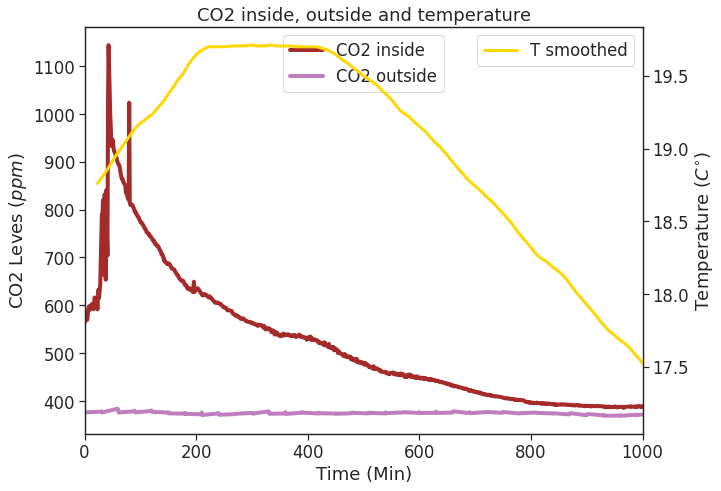

In [ ]:
# graph
fig, ax = plt.subplots(1, figsize=(10,7.5))
ax.plot(df_exp5["time(min)"],df_exp5['co2_in'],color = "brown",label='CO2 inside',  linewidth=4)
ax.plot(df_exp5["time(min)"],df_exp5['co2_out'],color = "purple",label='CO2 outside',  linewidth=4,alpha=.5)
ax.set(xlabel="Time (Min)",
       ylabel="CO2 Leves ($ppm$)",
       title="CO2 inside, outside and temperature");
ax.set_xlim(0,1000)
# ax.set_ylim(320,400)
plt.legend(loc='upper center')
ax2 = ax.twinx()
# ax2.plot(df_exp5["time(min)"],df_exp5['11_closet_north'],color = "seagreen",label='Temperature',  linewidth=3)
ax2.plot(df_exp5["time(min)"],df_exp5['11_closet_north'].rolling(45, center=True).mean(),color = "gold", label="T smoothed",linewidth=3, linestyle= "-")
ax2.set(xlabel="Time (Min)",
       ylabel="Temperature ($C^{\circ}$)");
# plt.axhline(y=0, color = "black")
plt.legend(loc='best')
# save_results_to = '/content/drive/Othercomputers/My Computer/Desktop/Greenwall/co2_and_counting_people/Co2_different_rooms_exp/rep5_room/'
# plt.savefig(save_results_to + 'rep4_room.png')

In [ ]:
import os  
# os.makedirs('folder/subfolder', exist_ok=True)  
df_exp5.to_csv('/content/drive/Othercomputers/My Computer/Desktop/Greenwall/co2_and_counting_people/Co2_different_rooms_exp/rep5_room/Dhelman_lab_Co2_data.csv')

# Rep 6 - New exp

In [ ]:
# df_exp6 = co2in_read("2022-03-21 12:50:00","2022-03-23 07:00:00")
co2in_path= "/content/drive/Othercomputers/My Computer/Desktop/Greenwall/co2_and_counting_people/Co2_different_rooms_exp/rep6_room/co2_in.xlsx"
df = pd.read_excel(co2in_path) # reading the raw date (xlsx)
#   # combine columns to datime:

In [ ]:
df = df.interpolate()
df['Hour'] = df['Hour'].astype(int)
df['Minute'] = df['Minute'].astype(int)
df['Month'] = df['Month'].astype(int)
df['Day'] = df['Day'].astype(int)
df['Year'] = 2022

time = (pd.to_datetime(df['Hour'].astype(str) + ':' + df['Minute'].astype(str), format='%H:%M').dt.time)
df['Time'] = time
df['Timestap'] = pd.to_datetime(df[["Year", "Month", "Day",'Hour','Minute']])
df_clean = df[['Timestap','Rec No.', 'CO2', 'Error']]
df_clean = df_clean.set_index(df_clean['Timestap'])
df_clean = df_clean.resample('1min').mean() # resample the data for comparing the with temp and co2 out
df_clean

Output hidden; open in https://colab.research.google.com to view.

11_closet_north
Time                                
2022-03-16 09:25:00            12.90
2022-03-16 09:26:00            12.89
2022-03-16 09:27:00            12.88
2022-03-16 09:28:00            12.87
2022-03-16 09:29:00            12.86
...                              ...
2022-03-23 09:21:00            14.21
2022-03-23 09:22:00            14.22
2022-03-23 09:23:00            14.23
2022-03-23 09:24:00            14.24
2022-03-23 09:25:00            14.25

[10081 rows x 1 columns]

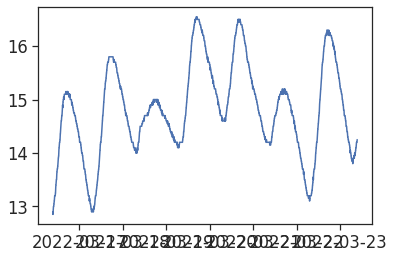

In [ ]:
# loading the data:
path= "/content/drive/Othercomputers/My Computer/Desktop/Greenwall/co2_and_counting_people/Co2_different_rooms_exp/rep6_room/lab_temp-data-2022-03-23 09_28_03.csv"
df_temp = pd.read_csv(path) # reading the raw date (csv)
df_temp = df_temp.set_index('Time')
df_temp.index = pd.to_datetime(df_temp.index) # convert to datime format
df_temp = df_temp.resample('1min').mean()
df_temp = df_temp.interpolate() # interpolate Nan values
plt.plot(df_temp)
df_temp

In [ ]:
start,end ="2022-03-22 14:00:00","2022-03-23 08:00:00"
df_temp =df_temp[start:end]
df_clean = df_clean[start:end]
df_exp6 = df_temp
df_exp6['co2_in'] = df_clean['CO2'] # for oresent them in the same graph i create  new df who incloud all co2 data
# df_co2_out = df_co2_out.loc[df_co2_out['Valve_no']== 10] # we want the data from outside - valve 10
# df_exp5['co2_out'] = df_co2_out['CO2_Avg'][start:end]
# df_exp5['co2_out'] = df_exp5['co2_out'].interpolate() # for oresent them in the same graph i create  new df who incloud all co2 data

time_values = np.arange(1, len(df_exp6['co2_in'])+1)
time_values=time_values.tolist()
df_exp6["time(min)"] = time_values
df_exp6

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


11_closet_north      co2_in  time(min)
Time                                                       
2022-03-22 14:00:00            15.55  618.711864          1
2022-03-22 14:01:00            15.57  620.600000          2
2022-03-22 14:02:00            15.59  619.338983          3
2022-03-22 14:03:00            15.61  618.866667          4
2022-03-22 14:04:00            15.63  620.084746          5
...                              ...         ...        ...
2022-03-23 07:56:00            13.96  398.000000       1077
2022-03-23 07:57:00            13.97  398.350000       1078
2022-03-23 07:58:00            13.98  398.508475       1079
2022-03-23 07:59:00            13.99  398.000000       1080
2022-03-23 08:00:00            14.00  397.694915       1081

[1081 rows x 3 columns]

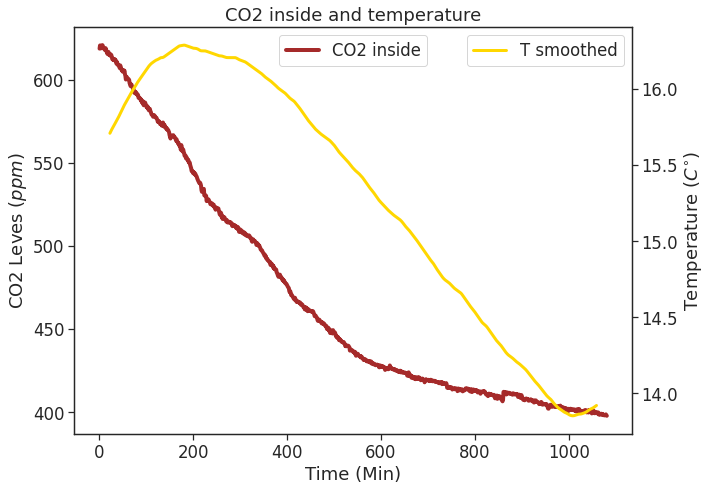

In [ ]:
# graph
fig, ax = plt.subplots(1, figsize=(10,7.5))
ax.plot(df_exp6["time(min)"],df_exp6['co2_in'],color = "brown",label='CO2 inside',  linewidth=4)
# ax.plot(df_exp6["time(min)"],df_exp6['co2_out'],color = "purple",label='CO2 outside',  linewidth=4,alpha=.5)
ax.set(xlabel="Time (Min)",
       ylabel="CO2 Leves ($ppm$)",
       title="CO2 inside and temperature");
# ax.set_xlim(0,1000)
# ax.set_ylim(320,400)
plt.legend(loc='upper center')
ax2 = ax.twinx()
# ax2.plot(df_exp6["time(min)"],df_exp6['11_closet_north'],color = "seagreen",label='Temperature',  linewidth=3)
ax2.plot(df_exp6["time(min)"],df_exp6['11_closet_north'].rolling(45, center=True).mean(),color = "gold", label="T smoothed",linewidth=3, linestyle= "-")
ax2.set(xlabel="Time (Min)",
       ylabel="Temperature ($C^{\circ}$)");
# plt.axhline(y=0, color = "black")
plt.legend(loc='best')
# save_results_to = '/content/drive/Othercomputers/My Computer/Desktop/Greenwall/co2_and_counting_people/Co2_different_rooms_exp/rep6_room/'
# plt.savefig(save_results_to + 'rep6_room.png')

# New gas 15 min

# Rep 7 - New exp

In [ ]:
# df_exp7 = co2in_read("","","2022-03-23 13:58:00","2022-03-24 07:00:00")

In [ ]:
co2in_path= "/content/drive/Othercomputers/My Computer/Desktop/Greenwall/co2_and_counting_people/Co2_different_rooms_exp/rep7_room/co2_in.xlsx"
df = pd.read_excel(co2in_path) # reading the raw date (xlsx)
#   # combine columns to datime:
df = df.interpolate()
df['Hour'] = df['Hour'].astype(int)
df['Minute'] = df['Minute'].astype(int)
df['Month'] = df['Month'].astype(int)
df['Day'] = df['Day'].astype(int)
df['Year'] = 2022

time = (pd.to_datetime(df['Hour'].astype(str) + ':' + df['Minute'].astype(str), format='%H:%M').dt.time)
df['Time'] = time
df['Timestap'] = pd.to_datetime(df[["Year", "Month", "Day",'Hour','Minute']])
df_clean = df[['Timestap','Rec No.', 'CO2', 'Error']]
df_clean = df_clean.set_index(df_clean['Timestap'])
df_clean = df_clean.resample('1min').mean() # resample the data for comparing the with temp and co2 out
df_clean

Rec No.         CO2     Error
Timestap                                          
2022-03-23 09:22:00   6961.0  399.852941  0.000000
2022-03-23 09:23:00   7055.0  399.316667  0.000000
2022-03-23 09:24:00   7174.0  399.847458  0.000000
2022-03-23 09:25:00   7293.0  399.666667  0.000000
2022-03-23 09:26:00   7412.0  401.322034  0.000000
...                      ...         ...       ...
2022-03-24 09:44:00   8837.0  420.966667  0.000000
2022-03-24 09:45:00   8956.0  421.966102  0.000000
2022-03-24 09:46:00   9075.0  421.200000  0.000000
2022-03-24 09:47:00   9194.0  422.593220  0.000000
2022-03-24 09:48:00   9308.0  623.945455  2.836364

[1467 rows x 3 columns]

11_closet_north
Time                                
2022-03-22 13:45:00            15.40
2022-03-22 13:46:00            15.41
2022-03-22 13:47:00            15.42
2022-03-22 13:48:00            15.43
2022-03-22 13:49:00            15.44
...                              ...
2022-03-24 13:36:00            14.00
2022-03-24 13:37:00            14.00
2022-03-24 13:38:00            14.00
2022-03-24 13:39:00            14.00
2022-03-24 13:40:00            14.00

[2876 rows x 1 columns]

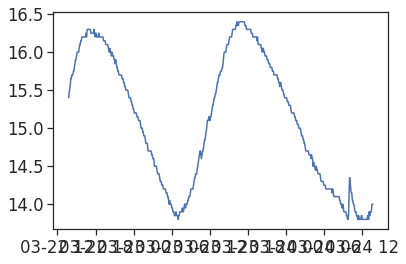

In [ ]:
# loading the data:
path= "/content/drive/Othercomputers/My Computer/Desktop/Greenwall/co2_and_counting_people/Co2_different_rooms_exp/rep7_room/lab_temp-data-2022-03-24 13_49_20.csv"
df_temp = pd.read_csv(path) # reading the raw date (csv)
df_temp = df_temp.set_index('Time')
df_temp.index = pd.to_datetime(df_temp.index) # convert to datime format
df_temp = df_temp.resample('1min').mean()
df_temp = df_temp.interpolate() # interpolate Nan values
plt.plot(df_temp)
df_temp

In [ ]:
start,end ="2022-03-23 13:58:00","2022-03-24 07:00:00"
df_temp =df_temp[start:end]
df_clean = df_clean[start:end]
df_exp7 = df_temp
df_exp7['co2_in'] = df_clean['CO2'] # for oresent them in the same graph i create  new df who incloud all co2 data
# df_co2_out = df_co2_out.loc[df_co2_out['Valve_no']== 10] # we want the data from outside - valve 10
# df_exp7['co2_out'] = df_co2_out['CO2_Avg'][start:end]
# df_exp7['co2_out'] = df_exp7['co2_out'].interpolate() # for oresent them in the same graph i create  new df who incloud all co2 data

time_values = np.arange(1, len(df_exp7['co2_in'])+1)
time_values=time_values.tolist()
df_exp7["time(min)"] = time_values
df_exp7

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


11_closet_north      co2_in  time(min)
Time                                                       
2022-03-23 13:58:00            15.80  416.250000          1
2022-03-23 13:59:00            15.80  417.830508          2
2022-03-23 14:00:00            15.80  418.576271          3
2022-03-23 14:01:00            15.81  419.200000          4
2022-03-23 14:02:00            15.82  419.830508          5
...                              ...         ...        ...
2022-03-24 06:56:00            14.20  403.350000       1019
2022-03-24 06:57:00            14.20  403.525424       1020
2022-03-24 06:58:00            14.20  403.033333       1021
2022-03-24 06:59:00            14.20  402.745763       1022
2022-03-24 07:00:00            14.20  402.383333       1023

[1023 rows x 3 columns]

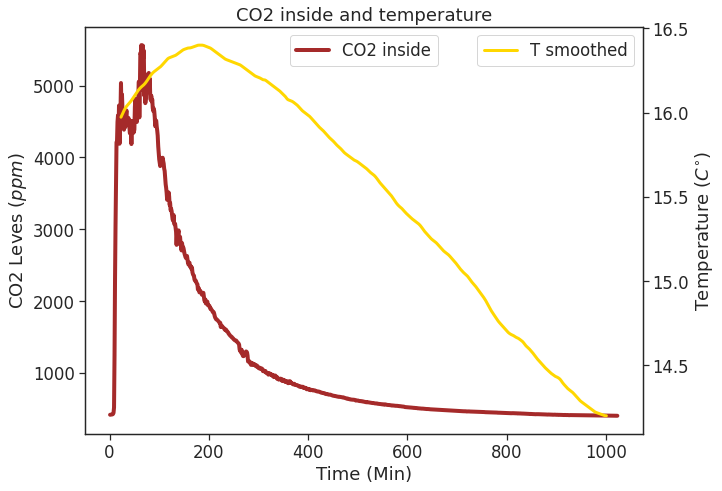

In [ ]:
# graph
fig, ax = plt.subplots(1, figsize=(10,7.5))
ax.plot(df_exp7["time(min)"],df_exp7['co2_in'],color = "brown",label='CO2 inside',  linewidth=4)
# ax.plot(df_exp7["time(min)"],df_exp7['co2_out'],color = "purple",label='CO2 outside',  linewidth=4,alpha=.5)
ax.set(xlabel="Time (Min)",
       ylabel="CO2 Leves ($ppm$)",
       title="CO2 inside and temperature");
# ax.set_xlim(0,1000)
# ax.set_ylim(320,400)
plt.legend(loc='upper center')
ax2 = ax.twinx()
# ax2.plot(df_exp7["time(min)"],df_exp7['11_closet_north'],color = "seagreen",label='Temperature',  linewidth=3)
ax2.plot(df_exp7["time(min)"],df_exp7['11_closet_north'].rolling(45, center=True).mean(),color = "gold", label="T smoothed",linewidth=3, linestyle= "-")
ax2.set(xlabel="Time (Min)",
       ylabel="Temperature ($C^{\circ}$)");
# plt.axhline(y=0, color = "black")
plt.legend(loc='best')
# save_results_to = '/content/drive/Othercomputers/My Computer/Desktop/Greenwall/co2_and_counting_people/Co2_different_rooms_exp/rep7_room/'
# plt.savefig(save_results_to + 'rep7_room.png')

# Rep8 - New Exp
04/05/2022

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


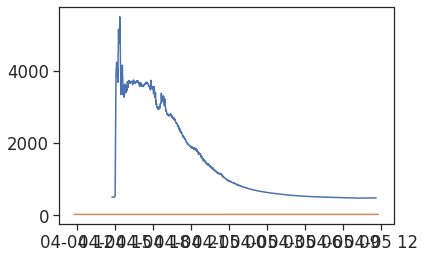

In [ ]:
root_path = "/content/drive/MyDrive/Greenwall/co2_and_counting_people/Co2_different_rooms_exp/rep8_room/"
df_exp8 = co2in_read_new("/content/drive/MyDrive/Greenwall/co2_and_counting_people/Co2_different_rooms_exp/rep8_room/co2_in.xlsx","/content/drive/MyDrive/Greenwall/co2_and_counting_people/Co2_different_rooms_exp/rep8_room/lab_temp-data-2022-04-05 11_47_47.csv","2022-04-04 15:00:00","2022-04-05 11:15:00")

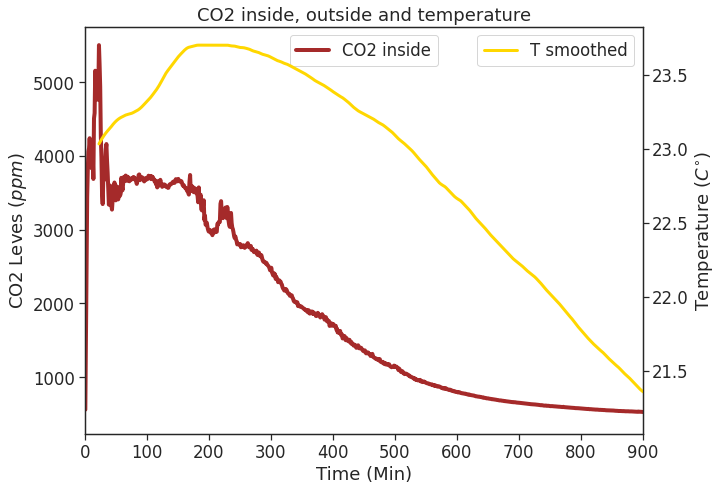

In [ ]:
# graph
fig, ax = plt.subplots(1, figsize=(10,7.5))
ax.plot(df_exp8["time(min)"],df_exp8['co2_in'],color = "brown",label='CO2 inside',  linewidth=4)
# ax.plot(df_exp8["time(min)"],df_exp8['co2_out'],color = "purple",label='CO2 outside',  linewidth=4,alpha=.5)
ax.set(xlabel="Time (Min)",
       ylabel="CO2 Leves ($ppm$)",
       title="CO2 inside, outside and temperature");
ax.set_xlim(0,900)
plt.legend(loc='upper center')
ax2 = ax.twinx()
# ax2.plot(df_exp8["time(min)"],df_exp8['11_closet_north'],color = "seagreen",label='Temperature',  linewidth=3)
ax2.plot(df_exp8["time(min)"],df_exp8['11_closet_north'].rolling(45, center=True).mean(),color = "gold", label="T smoothed",linewidth=3, linestyle= "-")
ax2.set(xlabel="Time (Min)",
       ylabel="Temperature ($C^{\circ}$)");
# plt.axhline(y=0, color = "black")
plt.legend(loc='best')
save_results_to = '/content/drive/Othercomputers/My Computer/Desktop/Greenwall/co2_and_counting_people/Co2_different_rooms_exp/rep8_room/'
# plt.savefig(save_results_to + 'rep8_room.png')

# Rep9 - New Exp
05/04/2022 14:40

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


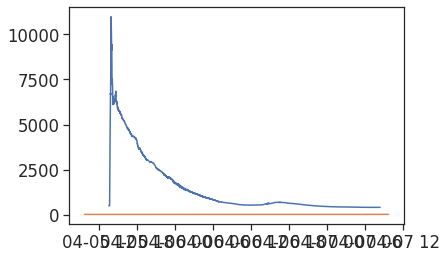

In [ ]:
df_exp9 = co2in_read_new("/content/drive/MyDrive/Greenwall/co2_and_counting_people/Co2_different_rooms_exp/rep9_room/co2in.xlsx","/content/drive/MyDrive/Greenwall/co2_and_counting_people/Co2_different_rooms_exp/rep9_room/lab_temp-data-2022-04-07 09_42_59.csv","2022-04-05 13:30:00","2022-04-06 11:15:00")
df_exp9 = co2col(df_co2_out,df_exp9,"2022-04-05 13:30:00","2022-04-06 11:15:00")

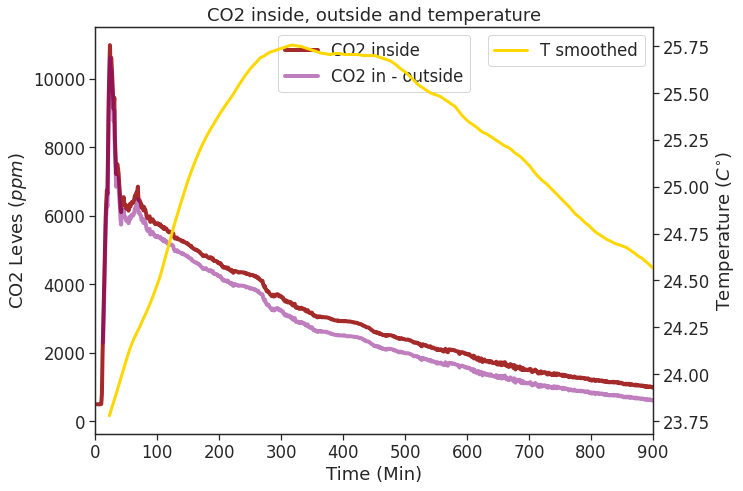

In [ ]:
# graph
fig, ax = plt.subplots(1, figsize=(10,7.5))
ax.plot(df_exp9["time(min)"],df_exp9['co2_in'],color = "brown",label='CO2 inside',  linewidth=4)
ax.plot(df_exp9["time(min)"],df_exp9['diff'],color = "purple",label='CO2 in - outside',  linewidth=4,alpha=.5)
ax.set(xlabel="Time (Min)",
       ylabel="CO2 Leves ($ppm$)",
       title="CO2 inside, outside and temperature");
ax.set_xlim(0,900)
plt.legend(loc='upper center')
ax2 = ax.twinx()
# ax2.plot(df_exp9["time(min)"],df_exp9['11_closet_north'],color = "seagreen",label='Temperature',  linewidth=3)
ax2.plot(df_exp9["time(min)"],df_exp9['11_closet_north'].rolling(45, center=True).mean(),color = "gold", label="T smoothed",linewidth=3, linestyle= "-")
ax2.set(xlabel="Time (Min)",
       ylabel="Temperature ($C^{\circ}$)");
# plt.axhline(y=0, color = "black")
plt.legend(loc='best')
save_results_to = '/content/drive/Othercomputers/My Computer/Desktop/Greenwall/co2_and_counting_people/Co2_different_rooms_exp/rep9_room/'
# plt.savefig(save_results_to + 'rep8_room.png')

# Rep10 - New Exp
07/04/2022 14:30

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


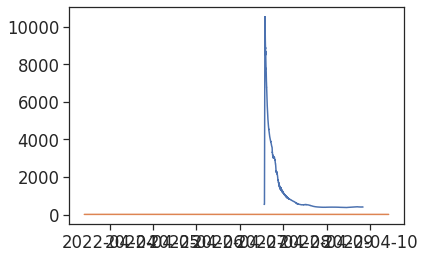

In [ ]:
df_exp10 = co2in_read_new("/content/drive/MyDrive/Greenwall/co2_and_counting_people/Co2_different_rooms_exp/rep10_room/co2_in.xlsx","/content/drive/MyDrive/Greenwall/co2_and_counting_people/Co2_different_rooms_exp/rep10_room/lab_temp-data-2022-04-10 10_07_40.csv","2022-04-07 13:50:00","2022-04-08 12:15:00")
df_exp10 = co2col(df_co2_out,df_exp10,"2022-04-07 13:50:00","2022-04-08 12:15:00")

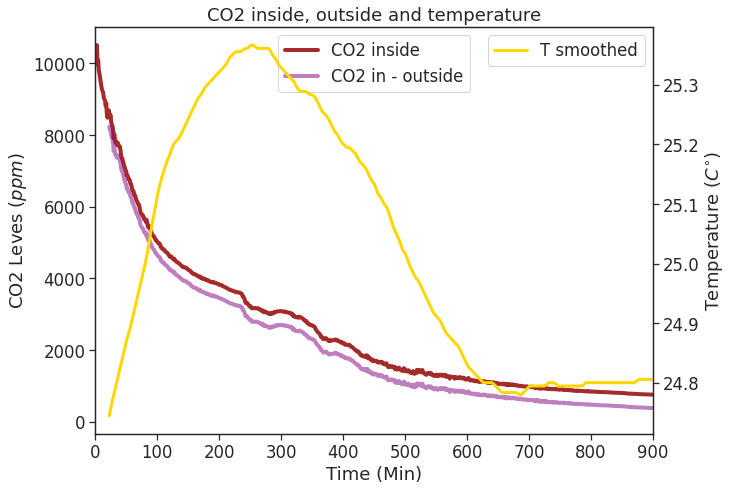

In [ ]:
# graph
fig, ax = plt.subplots(1, figsize=(10,7.5))
ax.plot(df_exp10["time(min)"],df_exp10['co2_in'],color = "brown",label='CO2 inside',  linewidth=4)
ax.plot(df_exp10["time(min)"],df_exp10['diff'],color = "purple",label='CO2 in - outside',  linewidth=4,alpha=.5)
ax.set(xlabel="Time (Min)",
       ylabel="CO2 Leves ($ppm$)",
       title="CO2 inside, outside and temperature");
ax.set_xlim(0,900)
plt.legend(loc='upper center')
ax2 = ax.twinx()
# ax2.plot(df_exp10["time(min)"],df_exp10['11_closet_north'],color = "seagreen",label='Temperature',  linewidth=3)
ax2.plot(df_exp10["time(min)"],df_exp10['11_closet_north'].rolling(45, center=True).mean(),color = "gold", label="T smoothed",linewidth=3, linestyle= "-")
ax2.set(xlabel="Time (Min)",
       ylabel="Temperature ($C^{\circ}$)");
# plt.axhline(y=0, color = "black")
plt.legend(loc='best')
save_results_to = '/content/drive/Othercomputers/My Computer/Desktop/Greenwall/co2_and_counting_people/Co2_different_rooms_exp/rep9_room/'
# plt.savefig(save_results_to + 'rep8_room.png')

# Rep11 - New Exp

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


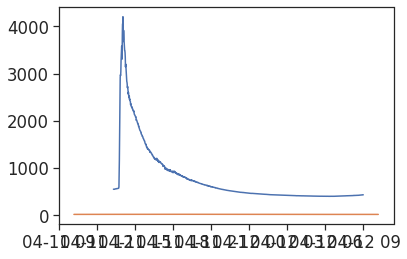

In [ ]:
df_exp11 = co2in_read_new("/content/drive/MyDrive/Greenwall/co2_and_counting_people/Co2_different_rooms_exp/rep11_room/co2_in.xlsx","/content/drive/MyDrive/Greenwall/co2_and_counting_people/Co2_different_rooms_exp/rep11_room/lab_temp-data-2022-04-12 10_13_32.csv","2022-04-11 13:00:00","2022-04-12 07:15:00")

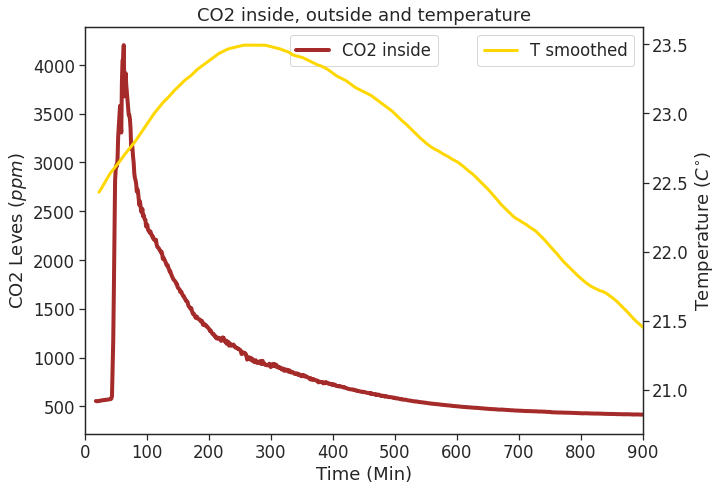

In [ ]:
# graph
fig, ax = plt.subplots(1, figsize=(10,7.5))
ax.plot(df_exp11["time(min)"],df_exp11['co2_in'],color = "brown",label='CO2 inside',  linewidth=4)
# ax.plot(df_exp11["time(min)"],df_exp11['co2_out'],color = "purple",label='CO2 outside',  linewidth=4,alpha=.5)
ax.set(xlabel="Time (Min)",
       ylabel="CO2 Leves ($ppm$)",
       title="CO2 inside, outside and temperature");
ax.set_xlim(0,900)
plt.legend(loc='upper center')
ax2 = ax.twinx()
# ax2.plot(df_exp11["time(min)"],df_exp11['11_closet_north'],color = "seagreen",label='Temperature',  linewidth=3)
ax2.plot(df_exp11["time(min)"],df_exp11['11_closet_north'].rolling(45, center=True).mean(),color = "gold", label="T smoothed",linewidth=3, linestyle= "-")
ax2.set(xlabel="Time (Min)",
       ylabel="Temperature ($C^{\circ}$)");
# plt.axhline(y=0, color = "black")
plt.legend(loc='best')
save_results_to = '/content/drive/Othercomputers/My Computer/Desktop/Greenwall/co2_and_counting_people/Co2_different_rooms_exp/rep9_room/'
# plt.savefig(save_results_to + 'rep8_room.png')

# Rep12 - New Exp

18/04/2022

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


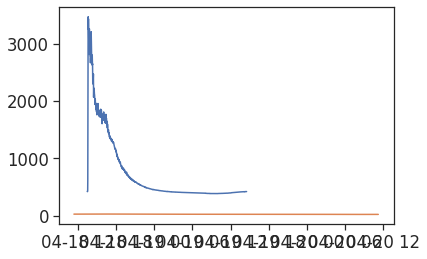

In [ ]:
df_exp12 = co2in_read_new("/content/drive/MyDrive/Greenwall/co2_and_counting_people/Co2_different_rooms_exp/rep12_room/co2_in.xlsx","/content/drive/MyDrive/Greenwall/co2_and_counting_people/Co2_different_rooms_exp/rep12_room/lab_temp-data-2022-04-20 11_20_05.csv","2022-04-18 13:29:00","2022-04-19 07:15:00")
df_exp12 = co2col(df_co2_out,df_exp12,"2022-04-18 13:29:00","2022-04-19 07:15:00")

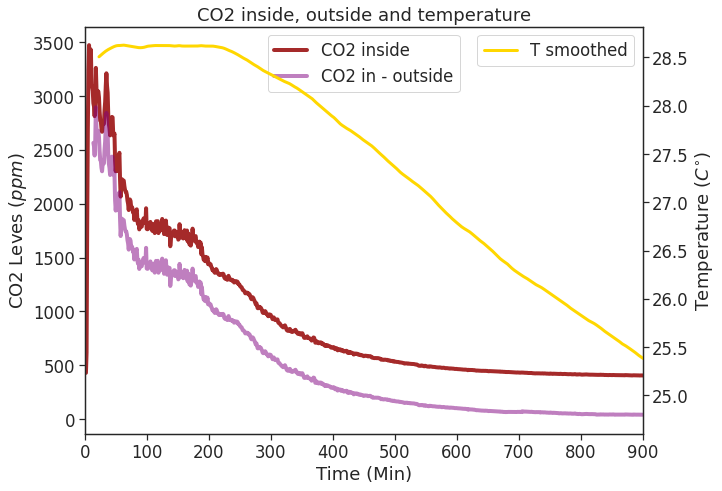

In [ ]:
# graph
fig, ax = plt.subplots(1, figsize=(10,7.5))
ax.plot(df_exp12["time(min)"],df_exp12['co2_in'],color = "brown",label='CO2 inside',  linewidth=4)
ax.plot(df_exp12["time(min)"],df_exp12['diff'],color = "purple",label='CO2 in - outside',  linewidth=4,alpha=.5)
ax.set(xlabel="Time (Min)",
       ylabel="CO2 Leves ($ppm$)",
       title="CO2 inside, outside and temperature");
ax.set_xlim(0,900)
plt.legend(loc='upper center')
ax2 = ax.twinx()
# ax2.plot(df_exp12["time(min)"],df_exp12['11_closet_north'],color = "seagreen",label='Temperature',  linewidth=3)
ax2.plot(df_exp12["time(min)"],df_exp12['11_closet_north'].rolling(45, center=True).mean(),color = "gold", label="T smoothed",linewidth=3, linestyle= "-")
ax2.set(xlabel="Time (Min)",
       ylabel="Temperature ($C^{\circ}$)");
# plt.axhline(y=0, color = "black")
plt.legend(loc='best')
save_results_to = '/content/drive/Othercomputers/My Computer/Desktop/Greenwall/co2_and_counting_people/Co2_different_rooms_exp/rep9_room/'
# plt.savefig(save_results_to + 'rep12_room.png')

# **Results room 1 all repititions**

In [ ]:
#  What is the index of the max co2 in value?
print(df_exp3[df_exp3['co2_in']==df_exp3['co2_in'].max()]['time(min)'].index)
print(df_exp2[df_exp2['co2_in']==df_exp2['co2_in'].max()]['time(min)'].index)
print(df_exp1[df_exp1['co2_in']==df_exp1['co2_in'].max()]['time(min)'].index)
print(df_exp4[df_exp4['co2_in']==df_exp4['co2_in'].max()]['time(min)'].index)
print(df_exp5[df_exp5['co2_in']==df_exp5['co2_in'].max()]['time(min)'].index)
print(df_exp6[df_exp6['co2_in']==df_exp6['co2_in'].max()]['time(min)'].index)
print(df_exp7[df_exp7['co2_in']==df_exp7['co2_in'].max()]['time(min)'].index)
print(df_exp8[df_exp8['co2_in']==df_exp8['co2_in'].max()]['time(min)'].index)
print(df_exp9[df_exp9['co2_in']==df_exp9['co2_in'].max()]['time(min)'].index)


NameError: ignored

In [ ]:
start1 = '2022-02-22 15:56:00'
start2 = '2022-02-24 16:23:00'
start3 = '2022-02-27 11:20:00'
start4 = "2022-03-01 12:32:00"
start5 = "2022-03-10 12:02:00"
start6 = '2022-03-22 14:06:00'
start7 = '2022-03-23 15:01:00'
start8 = "2022-04-04 15:22:00"
start9 = '2022-04-05 13:53:00'
start10 = "2022-04-07 13:52:00"
start11 = '2022-04-11 14:02:00'
start12 = '2022-04-18 13:35:00'

define t=0 while the co2 levels in maximum:

In [ ]:
# df_exp7 = df_exp7.loc[start7:]
# df_exp8 = df_exp8.loc[start8:]
df_exp9 = df_exp9.loc[start9:]
df_exp10 = df_exp10.loc[start10:]
# df_exp11 = df_exp11.loc[start11:]
df_exp12 = df_exp12.loc[start12:]
# t 0 will be the max value
dfs = [df_exp9,df_exp10,df_exp12]
for i in dfs:
  time_values = np.arange(1, len(i['co2_in'])+1)
  time_values=time_values.tolist()
  i["time(min)"] = time_values

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [ ]:
# df_exp1["diff_co2"] = df_exp1['co2_in'].diff()
# df_exp1["diff_time"] = df_exp1['time(min)'].diff()
# min1 = df_exp1[df_exp1["min1"]==df_exp1["min1"].min()]['time(min)']
# df_exp1['derive']=df_exp1["diff_co2"]/df_exp1["diff_time"]
# df_exp1 = df_exp1.resample('10min').mean()
# slope = pd.Series(np.gradient(df_exp1.co2_in), df_exp1.index, name='slope')
# df_exp1['slope'] = slope
# df_exp1 = pd.concat([df_exp1, slope], axis=1)
# plt.plot(df_exp1['time(min)'],df_exp1['co2_in'])
# df_exp1

In [ ]:
# df_exp4['co2_in'] = df_exp4['co2_in']-50
# df_exp2['co2_in'] = df_exp2['co2_in']-140

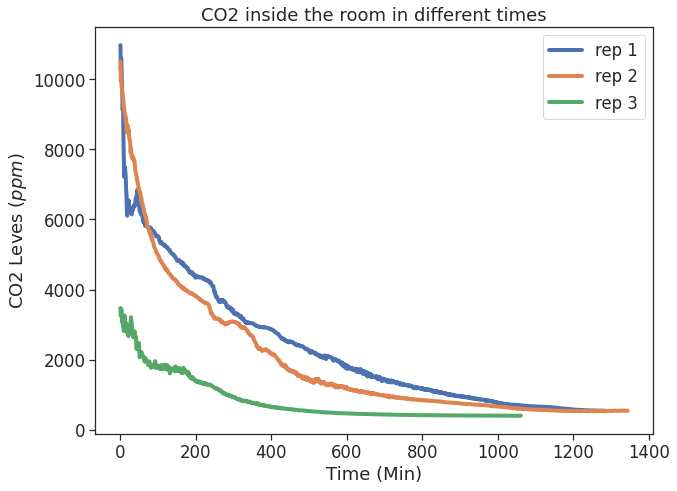

In [ ]:
 # graph
fig, ax = plt.subplots(1, figsize=(10,7.5))
# ax.plot(df_exp1.loc[start1:]["time(min)"],df_exp1.loc[start1:]['co2_in'],color = "salmon",label='rep 1',  linewidth=4)
# ax.plot(df_exp2.loc[start2:]["time(min)"],df_exp2.loc[start2:]['co2_in'],color = "seagreen",label='rep 2',  linewidth=4)
# ax.plot(df_exp3.loc[start3:]["time(min)"],df_exp3.loc[start3:]['co2_in'],color = "orange",label='rep 3',  linewidth=4)
# ax.plot(df_exp4.loc[start4:]["time(min)"],df_exp4.loc[start4:]['co2_in'],color = "orange",label='rep 4',  linewidth=4)
# ax.plot(df_exp5.loc[start5:]["time(min)"],df_exp5.loc[start5:]['co2_in'],color = "blue",label='rep 5',  linewidth=4)
# ax.plot(df_exp6.loc[start6:]["time(min)"],df_exp6.loc[start6:]['co2_in'],color = "green",label='rep 6',  linewidth=4)
# ax.plot(df_exp7.loc[start7:]["time(min)"],df_exp7.loc[start7:]['co2_in'],label='rep 1',  linewidth=4)
# ax.plot(df_exp8.loc[start8:]["time(min)"],df_exp8.loc[start8:]['co2_in'],label='rep 2',  linewidth=4)
# ax.plot(df_exp11.loc[start11:]["time(min)"],df_exp11.loc[start11:]['co2_in'],label='rep 5',  linewidth=4)

# in:
ax.plot(df_exp9.loc[start9:]["time(min)"],df_exp9.loc[start9:]['co2_in'],label='rep 1',  linewidth=4)
ax.plot(df_exp10.loc[start10:]["time(min)"],df_exp10.loc[start10:]['co2_in'],label='rep 2',  linewidth=4)
ax.plot(df_exp12.loc[start12:]["time(min)"],df_exp12.loc[start12:]['co2_in'],label='rep 3',  linewidth=4)

# # substructe out:
# ax.plot(df_exp9.loc[start9:]["time(min)"],df_exp9.loc[start9:]['diff'],label='rep 1',  linewidth=4)
# ax.plot(df_exp10.loc[start10:]["time(min)"],df_exp10.loc[start10:]['diff'],label='rep 2',  linewidth=4)
# ax.plot(df_exp12.loc[start12:]["time(min)"],df_exp12.loc[start12:]['diff'],label='rep 3',  linewidth=4)


ax.set(xlabel="Time (Min)",
       ylabel="CO2 Leves ($ppm$)",
       title="CO2 inside the room in different times");
# ax.set_ylim(350)
plt.legend(loc='best')
# save_results_to = '/content/drive/Othercomputers/My Computer/Desktop/Greenwall/co2_and_counting_people/Co2_different_rooms_exp/Graphs/'
# plt.savefig(save_results_to + 'room_all_reps.png')

## Normalized results:  max=3000 ppm


In [ ]:
max_value =3000

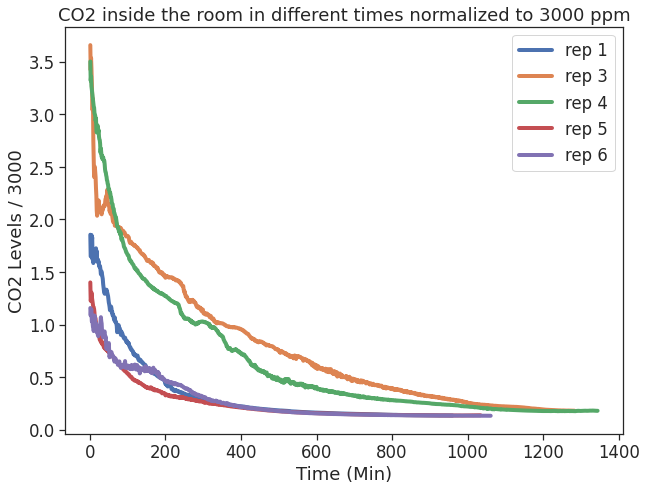

In [ ]:
 # graph
fig, ax = plt.subplots(1, figsize=(10,7.5))
# ax.plot(df_exp7.loc[start7:]["time(min)"],df_exp7.loc[start7:]['co2_in']/max_value,label='rep 1',  linewidth=4)
# ax.plot(df_exp8.loc[start8:]["time(min)"],df_exp8.loc[start8:]['co2_in']/max_value,label='rep 2',  linewidth=4)
ax.plot(df_exp9.loc[start9:]["time(min)"],df_exp9.loc[start9:]['co2_in']/max_value,label='rep 3',  linewidth=4)
ax.plot(df_exp10.loc[start10:]["time(min)"],df_exp10.loc[start10:]['co2_in']/max_value,label='rep 4',  linewidth=4)
# ax.plot(df_exp11.loc[start11:]["time(min)"],df_exp11.loc[start11:]['co2_in']/max_value,label='rep 5',  linewidth=4)
ax.plot(df_exp12.loc[start12:]["time(min)"],df_exp12.loc[start12:]['co2_in']/max_value,label='rep 6',  linewidth=4)
ax.set(xlabel="Time (Min)",
       ylabel="CO2 Levels / 3000",
       title="CO2 inside the room in different times normalized to 3000 ppm");
# ax.set_ylim(350)
plt.legend(loc='best')
# save_results_to = '/content/drive/Othercomputers/My Computer/Desktop/Greenwall/co2_and_counting_people/Co2_different_rooms_exp/Graphs/'
# plt.savefig(save_results_to + 'room_all_reps.png')

## Normalized results:  max= max value

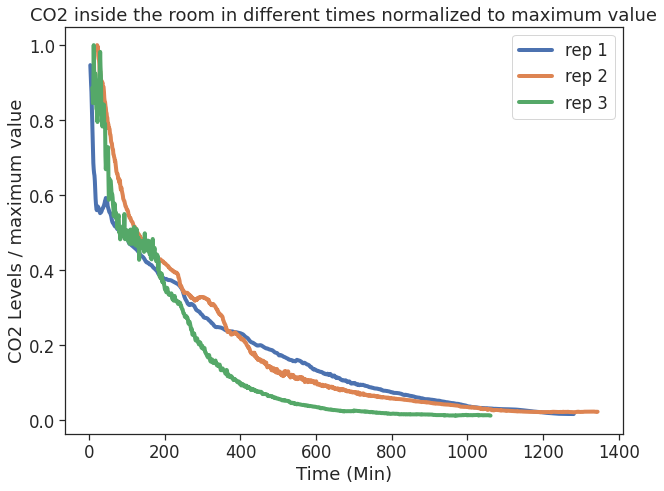

In [ ]:
 # graph
fig, ax = plt.subplots(1, figsize=(10,7.5))
# ax.plot(df_exp7.loc[start7:]["time(min)"],df_exp7.loc[start7:]['co2_in']/df_exp7['co2_in'].max(),label='rep 1',  linewidth=4)
# ax.plot(df_exp8.loc[start8:]["time(min)"],df_exp8.loc[start8:]['co2_in']/df_exp8['co2_in'].max(),label='rep 2',  linewidth=4)
# ax.plot(df_exp11.loc[start11:]["time(min)"],df_exp11.loc[start11:]['co2_in']/df_exp11['co2_in'].max(),label='rep 5',  linewidth=4)

# room
# ax.plot(df_exp9.loc[start9:]["time(min)"],df_exp9.loc[start9:]['co2_in'].rolling(5, center=True).mean()/df_exp9['co2_in'].max(),label='rep 1',  linewidth=4)
# ax.plot(df_exp10.loc[start10:]["time(min)"],df_exp10.loc[start10:]['co2_in'].rolling(5, center=True).mean()/df_exp10['co2_in'].max(),label='rep 2',  linewidth=4)
# ax.plot(df_exp12.loc[start12:]["time(min)"],df_exp12.loc[start12:]['co2_in'].rolling(5, center=True).mean()/df_exp12['co2_in'].max(),label='rep 3',  linewidth=4)

# room - out:
ax.plot(df_exp9.loc[start9:]["time(min)"],df_exp9.loc[start9:]['diff'].rolling(5, center=True).mean()/df_exp9['diff'].max(),label='rep 1',  linewidth=4)
ax.plot(df_exp10.loc[start10:]["time(min)"],df_exp10.loc[start10:]['diff']/df_exp10['diff'].max(),label='rep 2',  linewidth=4)
ax.plot(df_exp12.loc[start12:]["time(min)"],df_exp12.loc[start12:]['diff']/df_exp12['diff'].max(),label='rep 3',  linewidth=4)
ax.set(xlabel="Time (Min)",
       ylabel="CO2 Levels / maximum value",
       title="CO2 inside the room in different times normalized to maximum value");
# ax.set_ylim(350)
plt.legend(loc='best')
save_results_to = '/content/drive/Othercomputers/My Computer/Desktop/Greenwall/co2_and_counting_people/Co2_different_rooms_exp/Graphs/'
# plt.savefig(save_results_to + 'room_all_reps_subs_normalized.png')

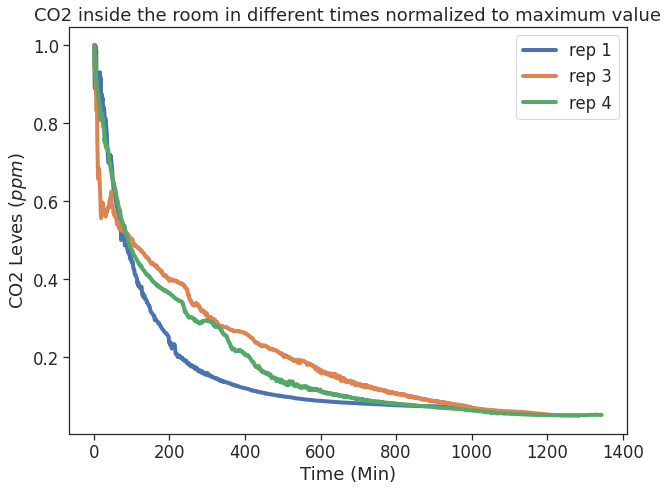

In [ ]:
 # graph
fig, ax = plt.subplots(1, figsize=(10,7.5))
ax.plot(df_exp7.loc[start7:]["time(min)"],df_exp7.loc[start7:]['co2_in']/df_exp7['co2_in'].max(),label='rep 1',  linewidth=4)
# ax.plot(df_exp8.loc[start8:]["time(min)"],df_exp8.loc[start8:]['co2_in']/df_exp8['co2_in'].max(),label='rep 2',  linewidth=4)
ax.plot(df_exp9.loc[start9:]["time(min)"],df_exp9.loc[start9:]['co2_in']/df_exp9['co2_in'].max(),label='rep 3',  linewidth=4)
ax.plot(df_exp10.loc[start10:]["time(min)"],df_exp10.loc[start10:]['co2_in']/df_exp10['co2_in'].max(),label='rep 4',  linewidth=4)

ax.set(xlabel="Time (Min)",
       ylabel="CO2 Leves ($ppm$)",
       title="CO2 inside the room in different times normalized to maximum value");
# ax.set_ylim(350)
plt.legend(loc='best')
# save_results_to = '/content/drive/Othercomputers/My Computer/Desktop/Greenwall/co2_and_counting_people/Co2_different_rooms_exp/Graphs/'
# plt.savefig(save_results_to + 'room_all_reps.png')

## Normalized results:  Differentially

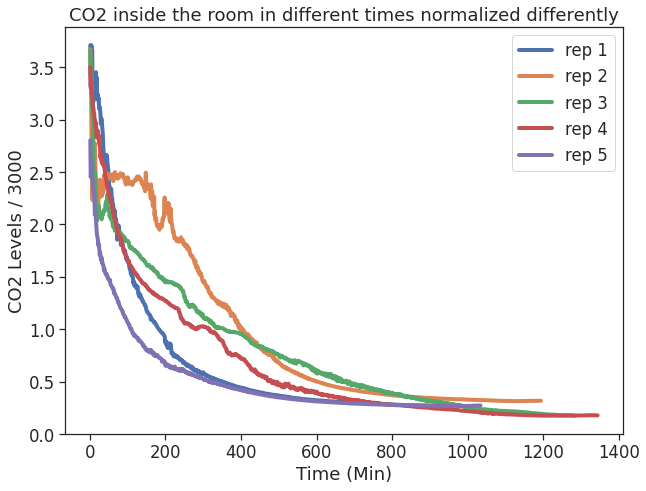

In [ ]:
 # graph
fig, ax = plt.subplots(1, figsize=(10,7.5))
ax.plot(df_exp7.loc[start7:]["time(min)"],df_exp7.loc[start7:]['co2_in']/1500,label='rep 1',  linewidth=4)
ax.plot(df_exp8.loc[start8:]["time(min)"],df_exp8.loc[start8:]['co2_in']/1500,label='rep 2',  linewidth=4)
ax.plot(df_exp9.loc[start9:]["time(min)"],df_exp9.loc[start9:]['co2_in']/max_value,label='rep 3',  linewidth=4)
ax.plot(df_exp10.loc[start10:]["time(min)"],df_exp10.loc[start10:]['co2_in']/max_value,label='rep 4',  linewidth=4)
ax.plot(df_exp11.loc[start11:]["time(min)"],df_exp11.loc[start11:]['co2_in']/1500,label='rep 5',  linewidth=4)
ax.set(xlabel="Time (Min)",
       ylabel="CO2 Levels / 3000",
       title="CO2 inside the room in different times normalized differently");
# ax.set_ylim(350)
plt.legend(loc='best')
# save_results_to = '/content/drive/Othercomputers/My Computer/Desktop/Greenwall/co2_and_counting_people/Co2_different_rooms_exp/Graphs/'
# plt.savefig(save_results_to + 'room_all_reps.png')

# Lab Exp


## Rep 1
24/04/2022 14:00

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


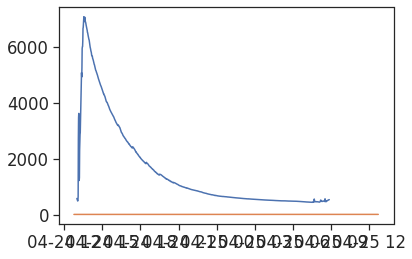

In [ ]:
lab1 = co2in_read_new("/content/drive/MyDrive/Greenwall/co2_and_counting_people/Co2_different_rooms_exp/lab_exps/lab1/co2_in.xlsx","/content/drive/MyDrive/Greenwall/co2_and_counting_people/Co2_different_rooms_exp/lab_exps/lab1/lab_temp-data-2022-04-25 12_49_23.csv","2022-04-24 13:05:00","2022-04-25 05:15:00")
lab1 = co2col(df_co2_out,lab1,"2022-04-24 13:05:00","2022-04-25 05:55:00")

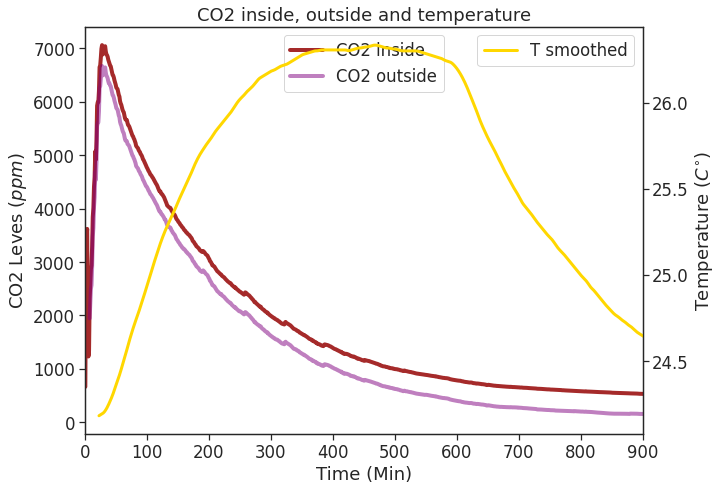

In [ ]:
# graph
fig, ax = plt.subplots(1, figsize=(10,7.5))
ax.plot(lab1["time(min)"],lab1['co2_in'],color = "brown",label='CO2 inside',  linewidth=4)
ax.plot(lab1["time(min)"],lab1['diff'],color = "purple",label='CO2 outside',  linewidth=4,alpha=.5)
ax.set(xlabel="Time (Min)",
       ylabel="CO2 Leves ($ppm$)",
       title="CO2 inside, outside and temperature");
ax.set_xlim(0,900)
plt.legend(loc='upper center')
ax2 = ax.twinx()
# ax2.plot(lab1["time(min)"],lab1['11_closet_north'],color = "seagreen",label='Temperature',  linewidth=3)
ax2.plot(lab1["time(min)"],lab1['11_closet_north'].rolling(45, center=True).mean(),color = "gold", label="T smoothed",linewidth=3, linestyle= "-")
ax2.set(xlabel="Time (Min)",
       ylabel="Temperature ($C^{\circ}$)");
# plt.axhline(y=0, color = "black")
plt.legend(loc='best')
save_results_to = '/content/drive/MyDrive/Greenwall/co2_and_counting_people/Co2_different_rooms_exp/lab_exps/lab1/'
# plt.savefig(save_results_to + 'rep12_room.png')

## Rep 2

29/04/2022 13:00


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


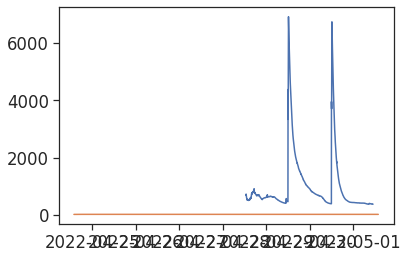

In [ ]:
lab2 = co2in_read_new("/content/drive/MyDrive/Greenwall/co2_and_counting_people/Co2_different_rooms_exp/lab_exps/lab2_3/lab2.xlsx","/content/drive/MyDrive/Greenwall/co2_and_counting_people/Co2_different_rooms_exp/lab_exps/lab2_3/lab_temp-data-2022-05-01 13_55_59.csv","2022-04-29 12:00:00","2022-04-30 03:15:00")
lab2 = co2col(df_co2_out,lab2,"2022-04-29 12:00:00","2022-04-30 05:55:00")

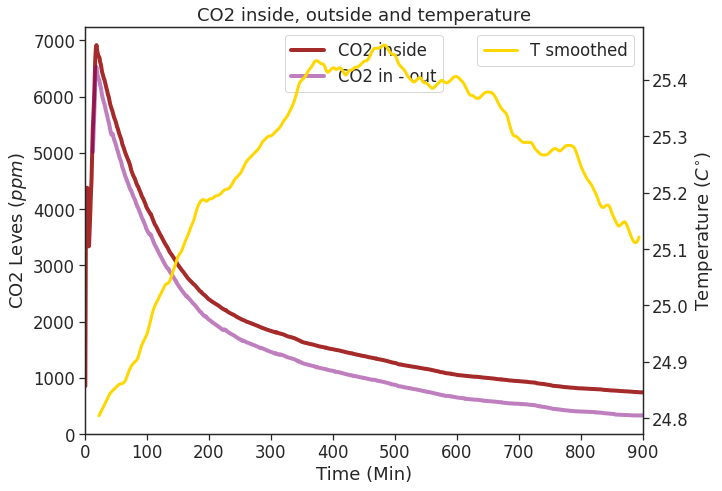

In [ ]:
# graph
fig, ax = plt.subplots(1, figsize=(10,7.5))
ax.plot(lab2["time(min)"],lab2['co2_in'],color = "brown",label='CO2 inside',  linewidth=4)
ax.plot(lab2["time(min)"],lab2['diff'],color = "purple",label='CO2 in - out',  linewidth=4,alpha=.5)
ax.set(xlabel="Time (Min)",
       ylabel="CO2 Leves ($ppm$)",
       title="CO2 inside, outside and temperature");
ax.set_xlim(0,900)
plt.legend(loc='upper center')
ax2 = ax.twinx()
# ax2.plot(lab2["time(min)"],lab2['11_closet_north'],color = "seagreen",label='Temperature',  linewidth=3)
ax2.plot(lab2["time(min)"],lab2['11_closet_north'].rolling(45, center=True).mean(),color = "gold", label="T smoothed",linewidth=3, linestyle= "-")
ax2.set(xlabel="Time (Min)",
       ylabel="Temperature ($C^{\circ}$)");
# plt.axhline(y=0, color = "black")
plt.legend(loc='best')
save_results_to = '/content/drive/MyDrive/Greenwall/co2_and_counting_people/Co2_different_rooms_exp/lab_exps/lab2_3/'
# plt.savefig(save_results_to + 'rep12_room.png')

## Rep 3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


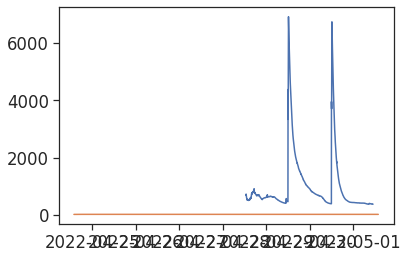

In [ ]:
lab3 = co2in_read_new("/content/drive/MyDrive/Greenwall/co2_and_counting_people/Co2_different_rooms_exp/lab_exps/lab2_3/lab2.xlsx","/content/drive/MyDrive/Greenwall/co2_and_counting_people/Co2_different_rooms_exp/lab_exps/lab2_3/lab_temp-data-2022-05-01 13_55_59.csv","2022-04-30 12:00:00","2022-05-01 02:15:00")
lab3 = co2col(df_co2_out,lab3,"2022-04-30 12:00:00","2022-05-01 05:55:00")

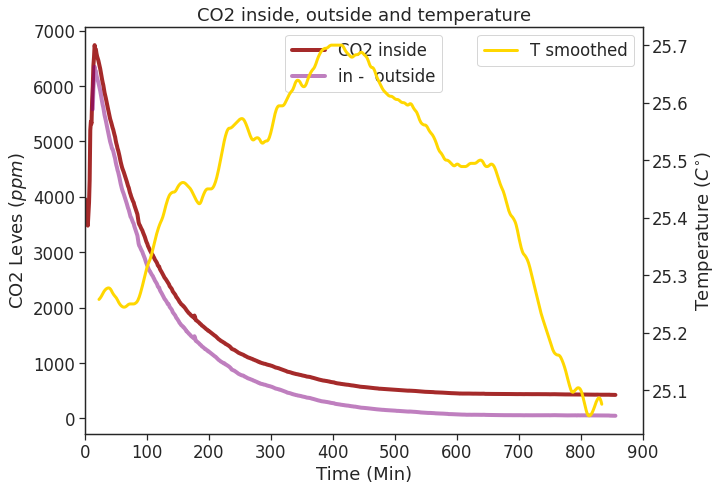

In [ ]:
# graph
fig, ax = plt.subplots(1, figsize=(10,7.5))
ax.plot(lab3["time(min)"],lab3['co2_in'],color = "brown",label='CO2 inside',  linewidth=4)
ax.plot(lab3["time(min)"],lab3['diff'],color = "purple",label='in -  outside',  linewidth=4,alpha=.5)
ax.set(xlabel="Time (Min)",
       ylabel="CO2 Leves ($ppm$)",
       title="CO2 inside, outside and temperature");
ax.set_xlim(0,900)
plt.legend(loc='upper center')
ax2 = ax.twinx()
# ax2.plot(lab3["time(min)"],lab3['11_closet_north'],color = "seagreen",label='Temperature',  linewidth=3)
ax2.plot(lab3["time(min)"],lab3['11_closet_north'].rolling(45, center=True).mean(),color = "gold", label="T smoothed",linewidth=3, linestyle= "-")
ax2.set(xlabel="Time (Min)",
       ylabel="Temperature ($C^{\circ}$)");
# plt.axhline(y=0, color = "black")
plt.legend(loc='best')
save_results_to = '/content/drive/MyDrive/Greenwall/co2_and_counting_people/Co2_different_rooms_exp/lab_exps/lab3_3/'
# plt.savefig(save_results_to + 'rep12_room.png')

## Rep 4

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


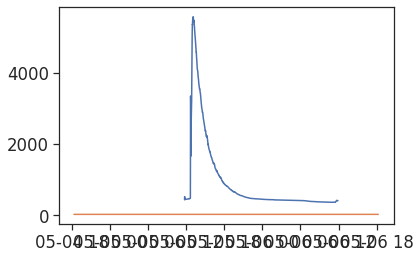

In [ ]:
lab4 = co2in_read_new("/content/drive/MyDrive/Greenwall/co2_and_counting_people/Co2_different_rooms_exp/lab_exps/lab_4/co2_in.xlsx",
                      "/content/drive/MyDrive/Greenwall/co2_and_counting_people/Co2_different_rooms_exp/lab_exps/lab_4/lab_temp-data-2022-05-06 18_19_55.csv",
                      "2022-05-05 11:50:00","2022-05-06 05:55:00")
lab4 = co2col(df_co2_out,lab4,"2022-05-05 11:50:00","2022-05-06 05:55:00")

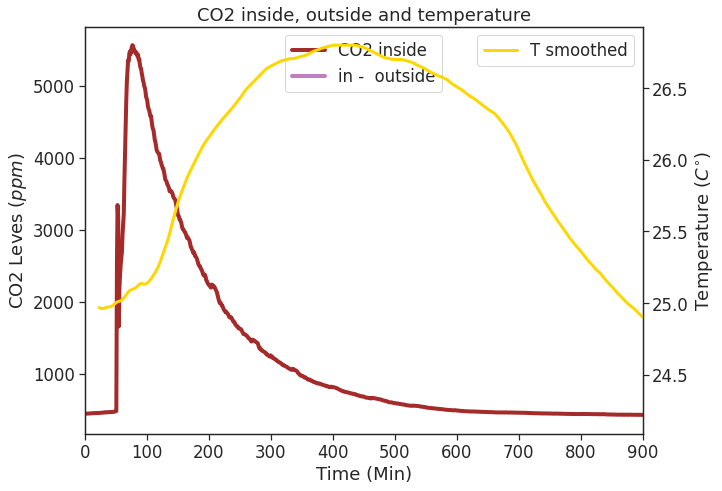

In [ ]:
# graph
fig, ax = plt.subplots(1, figsize=(10,7.5))
ax.plot(lab4["time(min)"],lab4['co2_in'],color = "brown",label='CO2 inside',  linewidth=4)
ax.plot(lab4["time(min)"],lab4['diff'],color = "purple",label='in -  outside',  linewidth=4,alpha=.5)
ax.set(xlabel="Time (Min)",
       ylabel="CO2 Leves ($ppm$)",
       title="CO2 inside, outside and temperature");
ax.set_xlim(0,900)
plt.legend(loc='upper center')
ax2 = ax.twinx()
# ax2.plot(lab4["time(min)"],lab4['11_closet_north'],color = "seagreen",label='Temperature',  linewidth=3)
ax2.plot(lab4["time(min)"],lab4['11_closet_north'].rolling(45, center=True).mean(),color = "gold", label="T smoothed",linewidth=3, linestyle= "-")
ax2.set(xlabel="Time (Min)",
       ylabel="Temperature ($C^{\circ}$)");
# plt.axhline(y=0, color = "black")
plt.legend(loc='best')
save_results_to = '/content/drive/MyDrive/Greenwall/co2_and_counting_people/Co2_different_rooms_exp/lab_exps/lab3_3/'
# plt.savefig(save_results_to + 'rep12_room.png')

# Results lab all reps 


In [ ]:
#  What is the index of the max co2 in value?
# print(lab1[lab1['co2_in']==lab1['co2_in'].max()]['time(min)'].index)
# print(lab2[lab2['co2_in']==lab2['co2_in'].max()]['time(min)'].index)
print(lab4[lab4['co2_in']==lab4['co2_in'].max()]['time(min)'].index)


DatetimeIndex(['2022-05-05 13:06:00'], dtype='datetime64[ns]', name='Time', freq='T')


In [ ]:
start_lab1 = '2022-04-24 13:32:00'
start_lab2 = "'2022-04-29 13:05:00'"
start_lab3 = "2022-04-30 12:15:00"
start_lab4 = '2022-05-05 13:06:00'

In [ ]:
lab1 = lab1.loc[start_lab1:]
# lab2 = lab2.loc[start_lab2:]
lab3 = lab3.loc[start_lab3:]
lab4 = lab4.loc[start_lab4:]
# t 0 will be the max value
dfs = [lab1,lab3,lab4]
for i in dfs:
  time_values = np.arange(1, len(i['co2_in'])+1)
  time_values=time_values.tolist()
  i["time(min)"] = time_values

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


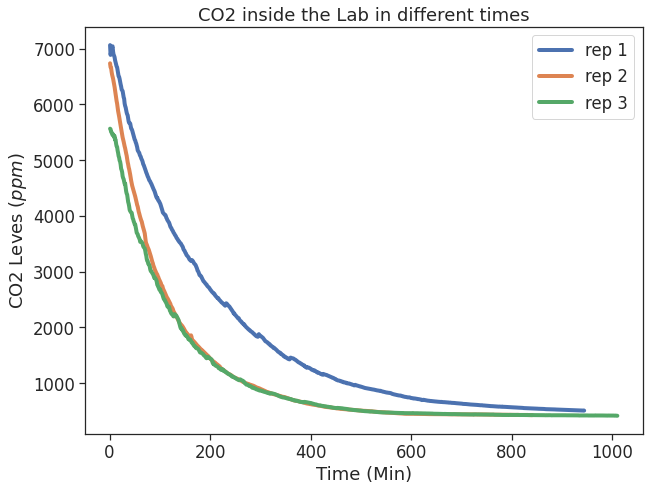

In [ ]:
fig, ax = plt.subplots(1, figsize=(10,7.5))
ax.plot(lab1.loc[start_lab1:]["time(min)"],lab1.loc[start_lab1:]['co2_in'],label='rep 1',  linewidth=4)
# ax.plot(lab2.loc[start_lab2:]["time(min)"],lab2.loc[start_lab2:]['co2_in'],label='rep 2',  linewidth=4)
ax.plot(lab3.loc[start_lab3:]["time(min)"],lab3.loc[start_lab3:]['co2_in'],label='rep 2',  linewidth=4)
ax.plot(lab4.loc[start_lab4:]["time(min)"],lab4.loc[start_lab4:]['co2_in'],label='rep 3',  linewidth=4)

# substructe co2 out:
# ax.plot(lab1.loc[start_lab1:]["time(min)"],lab1.loc[start_lab1:]['diff'],label='rep 1',  linewidth=4)
# ax.plot(lab2.loc[start_lab2:]["time(min)"],lab2.loc[start_lab2:]['diff'],label='rep 2',  linewidth=4)
# ax.plot(lab3.loc[start_lab3:]["time(min)"],lab3.loc[start_lab3:]['diff'],label='rep 3',  linewidth=4)
# ax.plot(lab4.loc[start_lab4:]["time(min)"],lab4.loc[start_lab3:]['diff'],label='rep 4',  linewidth=4)
ax.set(xlabel="Time (Min)",
       ylabel="CO2 Leves ($ppm$)",
       title="CO2 inside the Lab in different times");
plt.legend(loc='best')
save_results_to = '/content/drive/Othercomputers/My Computer/Desktop/Greenwall/co2_and_counting_people/Co2_different_rooms_exp/Graphs/'
# plt.savefig(save_results_to + 'lab_all_reps_substracted.png')

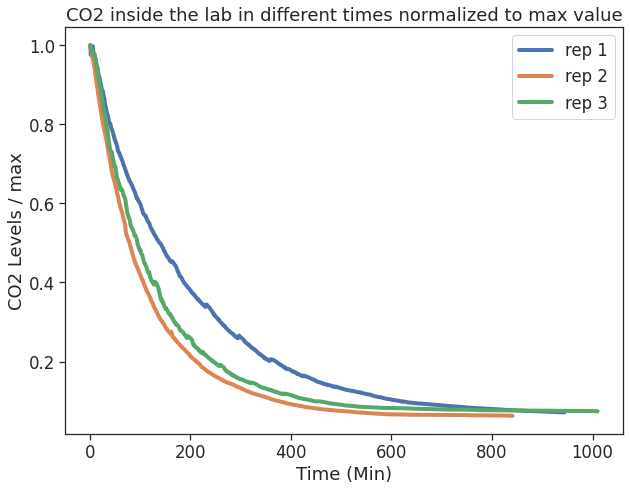

In [ ]:
# graph
fig, ax = plt.subplots(1, figsize=(10,7.5))
ax.plot(lab1.loc[start_lab1:]["time(min)"],lab1.loc[start_lab1:]['co2_in']/lab1['co2_in'].max(),label='rep 1',  linewidth=4)
# ax.plot(lab2.loc[start_lab2:]["time(min)"],lab2.loc[start_lab2:]['co2_in']/lab2['co2_in'].max(),label='rep 2',  linewidth=4)
ax.plot(lab3.loc[start_lab3:]["time(min)"],lab3.loc[start_lab3:]['co2_in']/lab3['co2_in'].max(),label='rep 2',  linewidth=4)
ax.plot(lab4.loc[start_lab4:]["time(min)"],lab4.loc[start_lab4:]['co2_in']/lab4['co2_in'].max(),label='rep 3',  linewidth=4)

# ax.plot(lab1.loc[start_lab1:]["time(min)"],lab1.loc[start_lab1:]['diff']/lab1['diff'].max(),label='rep 1',  linewidth=4)
# ax.plot(lab2.loc[start_lab2:]["time(min)"],lab2.loc[start_lab2:]['diff']/lab2['diff'].max(),label='rep 2',  linewidth=4)
# ax.plot(lab3.loc[start_lab3:]["time(min)"],lab3.loc[start_lab3:]['diff']/lab3['diff'].max(),label='rep 3',  linewidth=4)

ax.set(xlabel="Time (Min)",
       ylabel="CO2 Levels / max",
       title="CO2 inside the lab in different times normalized to max value");
# ax.set_ylim(350)
plt.legend(loc='best')
# save_results_to = '/content/drive/Othercomputers/My Computer/Desktop/Greenwall/co2_and_counting_people/Co2_different_rooms_exp/Graphs/'
# plt.savefig(save_results_to + 'lab_all_reps_noramlized.png')

# Final results 2 rooms

In [ ]:
df_avg = pd.DataFrame(index = lab3['time(min)'].values)
# room - out
df_avg["6"] = df_exp12['diff'][:len(df_avg.index)].values/df_exp12['diff'].max()
df_avg["3"] = df_exp9['diff'][:len(df_avg.index)].values/df_exp9['diff'].max()
df_avg["4"] = df_exp10['diff'][:len(df_avg.index)].values/df_exp10['diff'].max()



# lab - out co2
df_avg["lab1"] = lab1['diff'][:len(df_avg.index)].values/lab1['diff'].max()
df_avg["lab3"] = lab3['diff'][:len(df_avg.index)].values/lab3['diff'].max()
df_avg["lab4"] = lab4['diff'][:len(df_avg.index)].values/lab4['diff'].max()
df_avg["3_4_6_avg"] = df_avg[['6', '3', '4']].mean(axis=1)
df_avg["3_4_6_std"] = df_avg[['6', '3', '4']].std(axis=1)
df_avg["lab_avg"] = df_avg[["lab1","lab3", "lab4"]].mean(axis=1)
df_avg["lab_std"] = df_avg[["lab1","lab3", "lab4"]].std(axis=1)
# df_avg

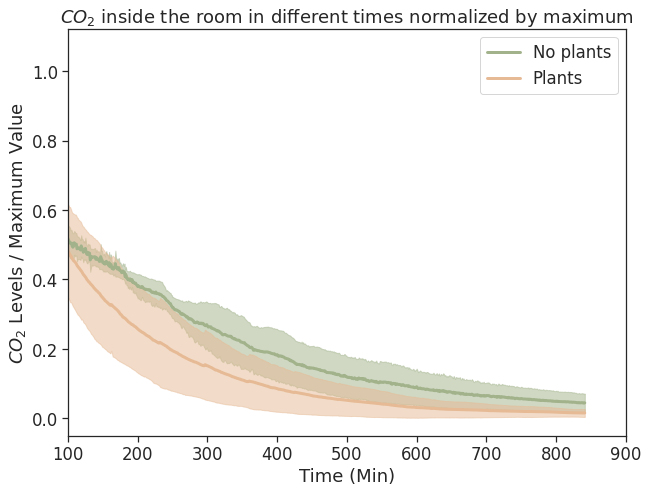

In [ ]:
fig, ax = plt.subplots(1, figsize=(10,7.5))
# room data:
ax.plot(df_avg["3_4_6_avg"],label='No plants',color="#A2B38B",  linewidth=3)
ax.fill_between(df_avg.index,df_avg["3_4_6_avg"] + df_avg["3_4_6_std"], df_avg["3_4_6_avg"] - df_avg["3_4_6_std"],color = "#A2B38B",alpha=.5)

# lab data
ax.plot(df_avg["lab_avg"],label='Plants',color="#E6BA95",  linewidth=3)
ax.fill_between(df_avg.index,df_avg["lab_avg"] + df_avg["lab_std"], df_avg["lab_avg"] - df_avg["lab_std"],color = "#E6BA95",alpha=.5)
ax.set(xlabel="Time (Min)",
       ylabel="$CO_2$ Levels / Maximum Value",
       title="$CO_2$ inside the room in different times normalized by maximum");
ax.set_xlim(100,900)
plt.legend(loc='best')

plt.savefig(save_results_to + 'final_results_full_100-900.png')

In [ ]:
df_avg = pd.DataFrame(index = lab3['time(min)'].values)
# room
df_avg["6"] = df_exp12['co2_in'][:len(df_avg.index)].values/df_exp12['co2_in'].max()
df_avg["3"] = df_exp9['co2_in'][:len(df_avg.index)].values/df_exp9['co2_in'].max()
df_avg["4"] = df_exp10['co2_in'][:len(df_avg.index)].values/df_exp10['co2_in'].max()

# lab
df_avg["lab1"] = lab1['co2_in'][:len(df_avg.index)].values/lab1['co2_in'].max()
df_avg["lab3"] = lab3['co2_in'][:len(df_avg.index)].values/lab3['co2_in'].max()
df_avg["lab4"] = lab4['co2_in'][:len(df_avg.index)].values/lab4['co2_in'].max()

df_avg["3_4_6_avg"] = df_avg[['6', '3', '4']].mean(axis=1)
df_avg["3_4_6_std"] = df_avg[['6', '3', '4']].std(axis=1)
df_avg["lab_avg"] = df_avg[["lab1","lab3", "lab4"]].mean(axis=1)
df_avg["lab_std"] = df_avg[["lab1","lab3", "lab4"]].std(axis=1)
# df_avg

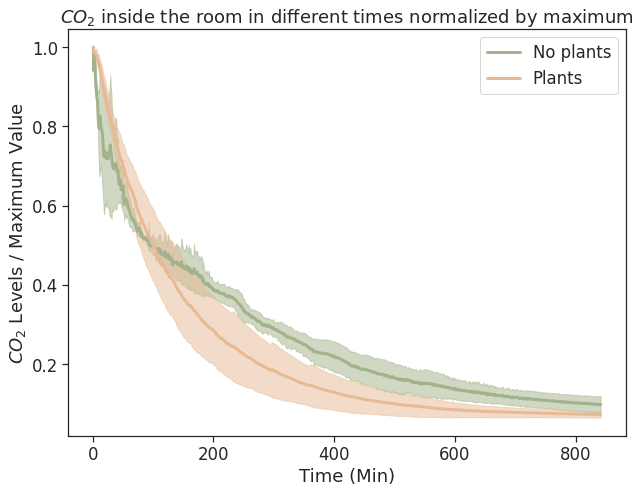

In [ ]:
fig, ax = plt.subplots(1, figsize=(10,7.5))
# room data:
ax.plot(df_avg["3_4_6_avg"],label='No plants',color="#A2B38B",  linewidth=3)
ax.fill_between(df_avg.index,df_avg["3_4_6_avg"] + df_avg["3_4_6_std"], df_avg["3_4_6_avg"] - df_avg["3_4_6_std"],color = "#A2B38B",alpha=.5)

# lab data
ax.plot(df_avg["lab_avg"],label='Plants',color="#E6BA95",  linewidth=3)
ax.fill_between(df_avg.index,df_avg["lab_avg"] + df_avg["lab_std"], df_avg["lab_avg"] - df_avg["lab_std"],color = "#E6BA95",alpha=.5)
ax.set(xlabel="Time (Min)",
       ylabel="$CO_2$ Levels / Maximum Value",
       title="$CO_2$ inside the room in different times normalized by maximum");
# ax.set_xlim(100,900)
plt.legend(loc='best')
# save_results_to = '/content/drive/Othercomputers/My Computer/Desktop/Greenwall/co2_and_counting_people/Co2_different_rooms_exp/Graphs/'
# plt.savefig(save_results_to + 'final_results_full_sub.png')